In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import os
import numpy as np
from scipy.stats import skew, kurtosis
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import statsmodels.api as sm
from scipy.stats import zscore
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.collections import PolyCollection, LineCollection
import matplotlib.pyplot as plt

In [2]:
# file_path =r'C:\Users\Leo Hubmann\Desktop\thesis\data\price_data\bitcoin_2021_2024.csv'
file_path =r'C:\Users\Leo Hubmann\Desktop\thesis\data\price_data\bitcoin_2009_2025current.csv'

df = pd.read_csv(file_path, low_memory=False)

In [3]:
# prepare data (time)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

BTC Price History Graph

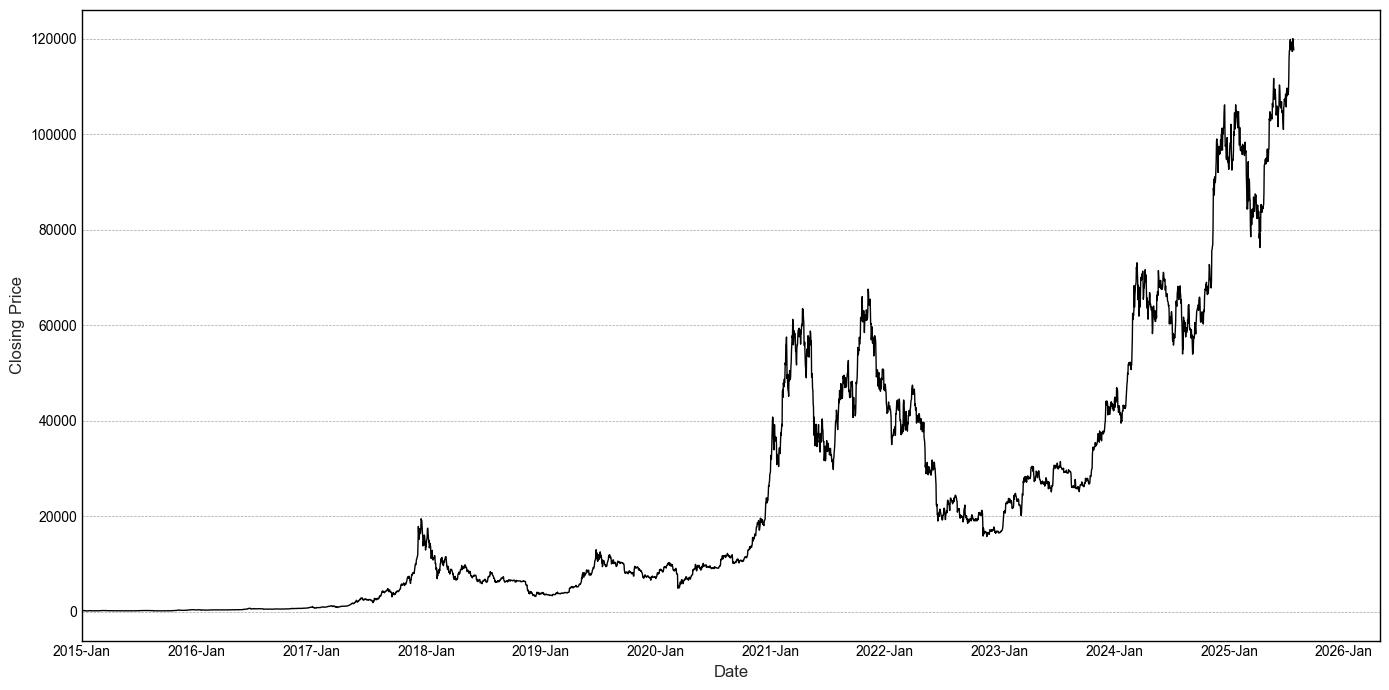

In [4]:
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(df.index, df['close'], color='black', linewidth=1.0, label='Daily Closing Price')

ax.set_xlim(left=pd.to_datetime('2015-01-01'))

ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Closing Price', fontsize=12)
# ax.set_title('Bitcoin Daily Closing Prices (until March 2025)', fontsize=14)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=15))

#plt.xticks(rotation=30, ha='right')

ax.grid(True, which='major', axis='y', linestyle='--', linewidth='0.5', color='grey', alpha=0.7)
ax.grid(False, which='major', axis='x')

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

plt.tight_layout()
plt.savefig("priceHistFULL.png", dpi=300, bbox_inches="tight")
plt.show()

BTC Price History Graph 2021 - 2024 Plots

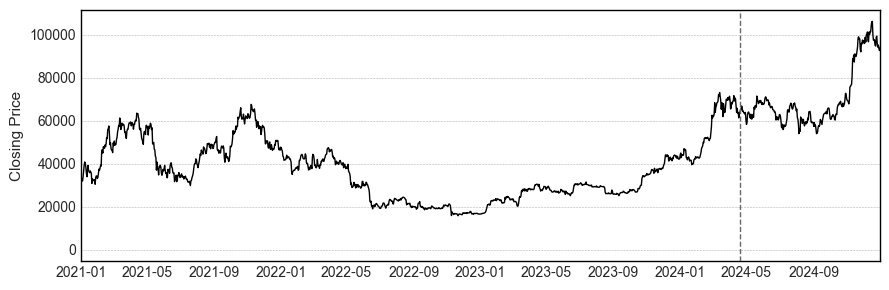

In [87]:
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(figsize=(9, 3))

ax.plot(df.index, df['close'], color='black', linewidth=1.0, label='Daily Closing Price')

# Set x-axis limits to start from 2021-01-01 and end at 2024-12-31
ax.set_xlim(left=pd.to_datetime('2021-01-01'), right=pd.to_datetime('2024-12-31'))

ax.axvline(pd.to_datetime('2024-04-20'), color='dimgray', linestyle='--', linewidth=1, label='20 April 2024')

ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

ax.set_ylabel('Closing Price', fontsize=11)
# ax.set_title('Bitcoin Daily Closing Prices (until March 2025)', fontsize=14)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=15))

#plt.xticks(rotation=30, ha='right')

ax.grid(True, axis="y", ls="--", lw=0.4, color="grey", alpha=0.6)
ax.grid(False, which='major', axis='x')


plt.tight_layout()

plt.savefig("plotprice.png", dpi=300, bbox_inches="tight")
plt.show()

In [88]:
# ---- 1. make the slice first ---------------------------------
mask = (df.index >= "2021-01-01") & (df.index <= "2024-12-31")
btc   = df.loc[mask].sort_index()              # <= only 2021-24 rows

# ---- 2. compute log-returns on that slice --------------------
daily_ret = np.log(btc['close']).diff().dropna()

# ---- 3. summary stats ----------------------------------------
desc = daily_ret.describe().T
desc['skew'] = skew(daily_ret)
desc['kurt'] = kurtosis(daily_ret, fisher=True)

print("Bitcoin daily log-return statistics (2021-2024)\n")
print(desc)

Bitcoin daily log-return statistics (2021-2024)

count    1460.000000
mean        0.000793
std         0.032387
min        -0.174053
25%        -0.013864
50%        -0.000008
75%         0.015895
max         0.171821
skew       -0.139881
kurt        3.491121
Name: close, dtype: float64


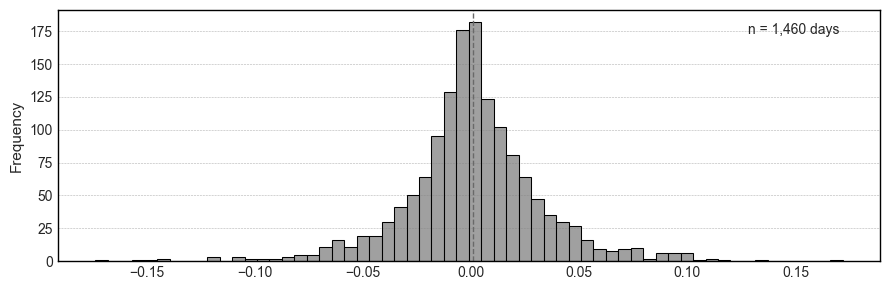

In [89]:
# --- 1. make sure the index is datetime and slice the period -----------------
df.index = pd.to_datetime(df.index) 
btc_21_24 = df.loc["2021-01-01":"2024-12-31"].copy()

# --- 2. compute daily log-returns for **this slice** -------------------------
daily_ret = np.log(btc_21_24['close']).diff().dropna()

# --- 3. plot -----------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(figsize=(9, 3))

sns.histplot( daily_ret,
             bins=60,
             # stat='frequency',
             color='grey',
             edgecolor='black',
             ax=ax)
ax.axvline(daily_ret.mean(), color='dimgray', lw=1, ls='--')

ax.text(
    0.95, 0.95,              # Position (x, y) in axes coordinates
    'n = 1,460 days',        # Text to display
    transform=ax.transAxes,  # Use axes coordinates
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right'
)

ax.set_xlabel('')

ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

ax.grid(True, axis="y", ls="--", lw=0.4, color="grey", alpha=0.6)
ax.grid(False, which='major', axis='x')

# labels & cosmetics
#ax.set_xlabel("Daily log-return (2021-2024)", fontsize=11)
ax.set_ylabel("Frequency", fontsize=11)

plt.tight_layout()
plt.savefig("priceHist.png", dpi=300, bbox_inches="tight")
plt.show()

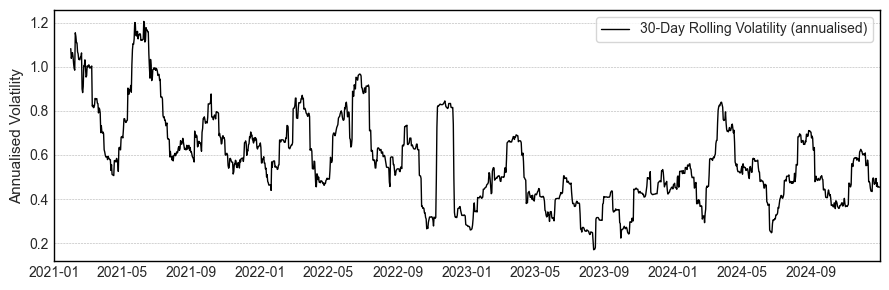

In [29]:
plt.style.use('seaborn-v0_8-whitegrid')

df_slice = df.loc['2021-01-01':'2024-12-31'].copy()
df_slice['log_ret'] = np.log(df_slice['close']).diff()

window = 30                           # rolling window length
df_slice['roll_vol'] = (df_slice['log_ret']          # daily σ
                        .rolling(window)
                        .std()
                        * np.sqrt(365))              # annualise


fig, ax = plt.subplots(figsize=(9, 3))

ax.plot(df_slice.index,
        df_slice['roll_vol'],
        color='black',
        linewidth=1.0,
        label='30-Day Rolling Volatility (annualised)')

# x-axis limits (match price chart)
ax.set_xlim(pd.to_datetime('2021-01-01'),
            pd.to_datetime('2024-12-31'))

# frame styling consistent with your price plot
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_color('black')

ax.set_ylabel('Annualised Volatility', fontsize=11)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=15))

ax.grid(True, axis="y", ls="--", lw=0.4, color="grey", alpha=0.6)
ax.grid(False, which='major', axis='x')

ax.legend(frameon=True)
plt.tight_layout()
plt.savefig('btc_rolling_volatility.png', dpi=300, bbox_inches="tight")
plt.show()

C:\Users\Leo Hubmann\AppData\Local\Temp\ipykernel_9696\3439610417.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=True)


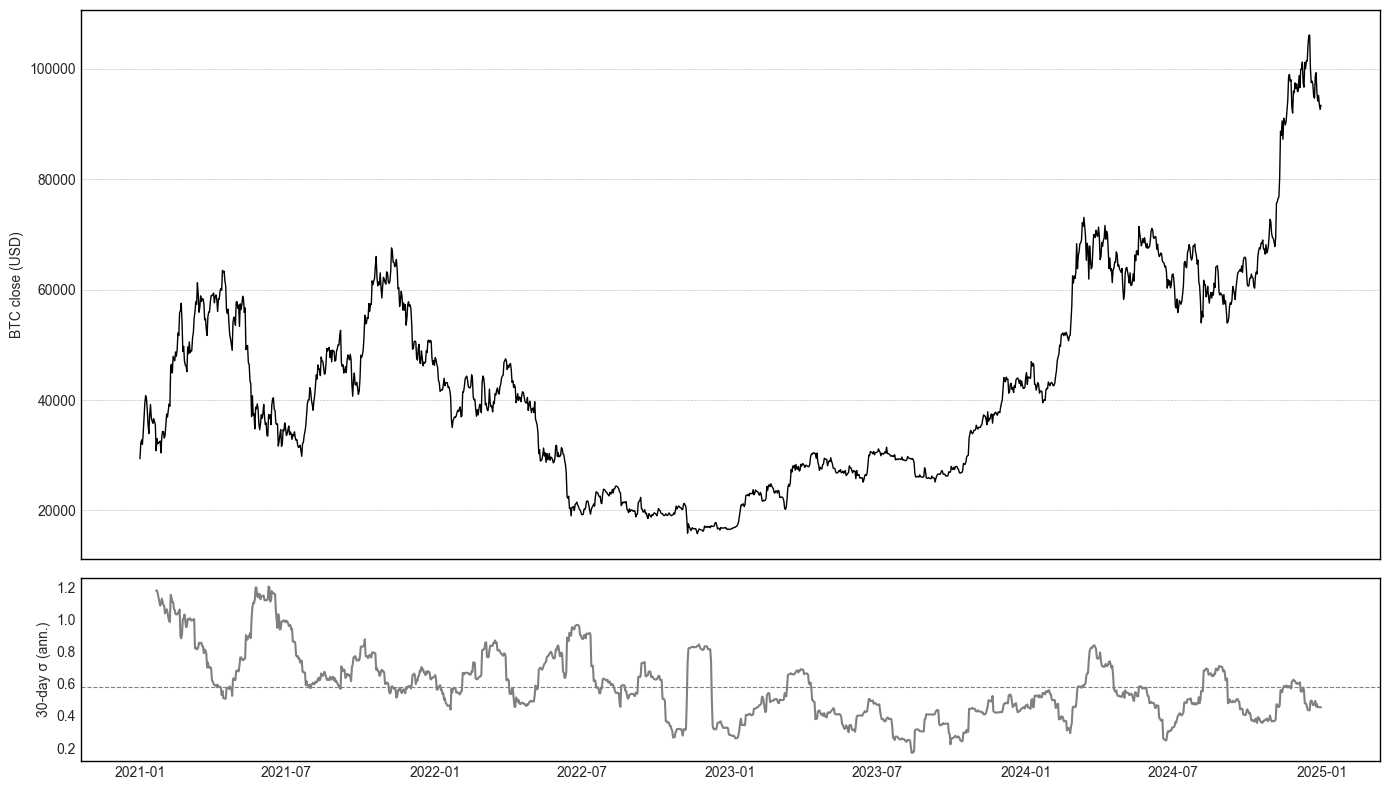

In [90]:
# ---- rolling volatility series ----------------------------------
rolling_vol = (
    daily_ret.rolling(window=30, min_periods=20)   # ≈ one month
              .std() * np.sqrt(365)                # annualise (optional)
)

# ---- plot price + volatility ------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax_price, ax_vol) = plt.subplots(
    2, 1, figsize=(14, 8), sharex=True,
    gridspec_kw={'height_ratios':[3,1]}
)

ax_price.plot(btc.index, btc['close'], color='black', lw=1)
ax_price.set_ylabel("BTC close (USD)")

ax_vol.plot(rolling_vol.index, rolling_vol, color='gray')
ax_vol.set_ylabel("30-day σ (ann.)")

ax_vol.axhline(rolling_vol.mean(), ls='--', lw=0.8, color='gray')

ax_vol.spines['top'].set_color('black')
ax_vol.spines['right'].set_color('black')
ax_vol.spines['left'].set_color('black')
ax_vol.spines['bottom'].set_color('black')

ax_price.spines['top'].set_color('black')
ax_price.spines['right'].set_color('black')
ax_price.spines['left'].set_color('black')
ax_price.spines['bottom'].set_color('black')

ax_price.grid(True, axis="y", ls="--", lw=0.4, color="grey", alpha=0.6)
ax_price.grid(False, which='major', axis='x')

ax.legend(frameon=True)
ax_vol.grid(False)

plt.tight_layout()
plt.savefig("plotcombined.png", dpi=300, bbox_inches="tight")
plt.show()

EDA Sentiment Plots

In [4]:
df = pd.read_csv(r'C:\Users\Leo Hubmann\Desktop\BachelorThesis_data\all_daily_vader_sentiment_v2.csv', parse_dates=['date'])

In [92]:
def plot_acf_grey(series, lags=30, ci_colour="lightgrey", ci_alpha=0.4,
                  stem_colour="black", grid=True, filename=None):
    """
    series      1-d array-like
    lags        number of lags
    ci_colour   fill colour of CI band  (None → remove band)
    ci_alpha    transparency 0–1
    stem_colour colour of stems and markers
    grid        show y-axis grid
    filename    if given, save the figure to this file
    """
    fig, ax = plt.subplots(figsize=(9, 2.5))

    # plot ACF with default CI
    plot_acf(series, lags=lags, zero=False, title='',
             ax=ax,
             color=stem_colour,
             vlines_kwargs={"colors": stem_colour})

    # --- restyle collections created by statsmodels -----------------
    for obj in ax.collections:
        if isinstance(obj, PolyCollection):           # confidence band
            if ci_colour is None:
                obj.set_alpha(0)                      # remove band
            else:
                obj.set_facecolor(ci_colour)
                obj.set_alpha(ci_alpha)
        elif isinstance(obj, LineCollection):         # vertical stems
            obj.set_color(stem_colour)

    # horizontal zero-line = first element in ax.lines list
    ax.lines[0].set_color(stem_colour)

    # spines & grid
    for sp in ax.spines.values():
        sp.set_color("black")
    if grid:
        ax.grid(True, axis="y", ls="--", lw=0.4, color="grey", alpha=0.6)
        ax.grid(False, axis="x")

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    return fig, ax

In [93]:
def plot_histogram(series, filename):
    """
    Plot a histogram of `series` and save it to `filename`.

    series   : 1-d array-like
    filename : output file path (including extension, e.g. .png)
    """
    plt.style.use('seaborn-v0_8-whitegrid')

    fig, ax = plt.subplots(figsize=(9, 3))
    sns.histplot(series,
                 bins=60,
                 color='grey',
                 edgecolor='black',
                 ax=ax)

    ax.axvline(series.mean(), color='dimgray', lw=1, ls='--')

    ax.set_ylabel("Frequency", fontsize=11)
    ax.set_xlabel('')

    for sp in ax.spines.values():
        sp.set_color('black')

    ax.grid(True, axis="y", ls="--", lw=0.4, color="grey", alpha=0.6)
    ax.grid(False, which='major', axis='x')

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)  # close to free memory


In [5]:
v_series = df['daily_vader_sentiment']

desc = v_series.describe().T
desc['skew'] = skew(v_series)
desc['kurt'] = kurtosis(v_series, fisher=True)
display(desc)

count    1462.000000
mean        0.189687
std         0.029119
min         0.091232
25%         0.170847
50%         0.189793
75%         0.208861
max         0.404624
skew        0.139972
kurt        2.007667
Name: daily_vader_sentiment, dtype: float64

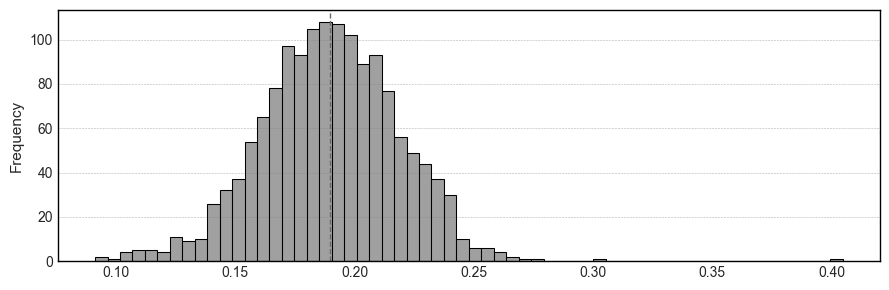

In [58]:
plot_histogram(v_series, "vaderhisto.png")

(<Figure size 900x250 with 1 Axes>, <Axes: >)

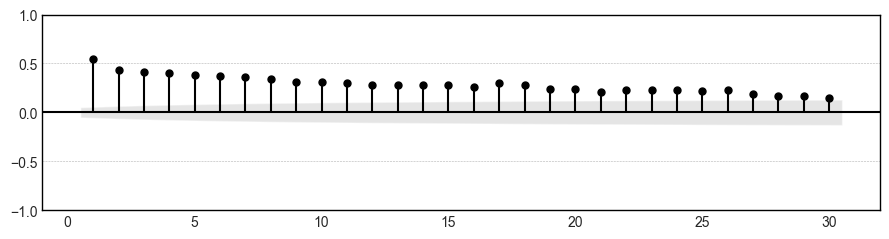

In [59]:
plot_acf_grey(v_series, lags=30, ci_colour="silver", ci_alpha=0.4, filename="vaderS_acf.png")

In [6]:
df = pd.read_csv(r'C:\Users\Leo Hubmann\Desktop\BachelorThesis_data\all_daily_finbert_sentiment_v4.csv', parse_dates=['date'])

In [7]:
f_series = df['daily_finbert_score']

desc = f_series.describe().T
desc['skew'] = skew(f_series)
desc['kurt'] = kurtosis(f_series, fisher=True)

display(desc)

count    1462.000000
mean       -0.165154
std         0.083256
min        -0.368623
25%        -0.223489
50%        -0.168568
75%        -0.110454
max         0.304444
skew        0.439246
kurt        0.767671
Name: daily_finbert_score, dtype: float64

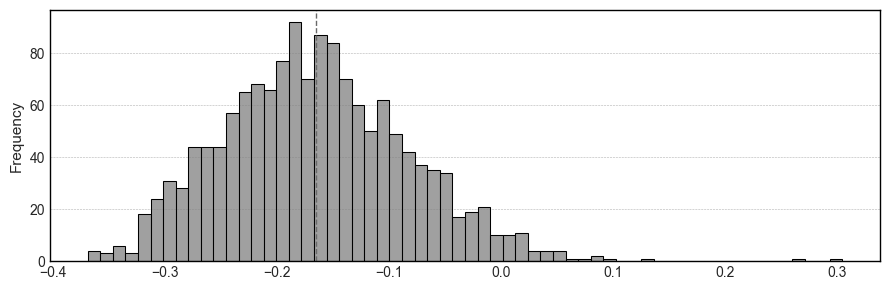

In [69]:
plot_histogram(f_series, "finberthisto.png")

(<Figure size 900x250 with 1 Axes>, <Axes: >)

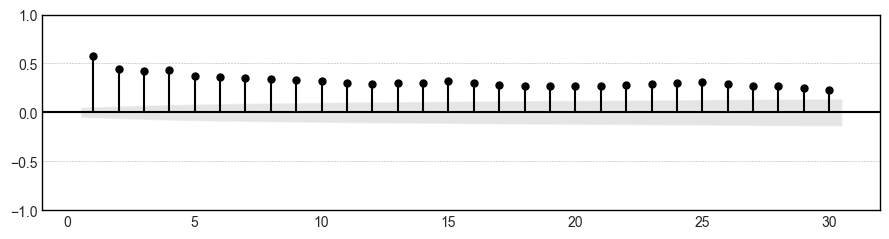

In [70]:
plot_acf_grey(f_series, lags=30, ci_colour="silver", ci_alpha=0.4, filename="finbertS_acf.png")

EDA Sentiment vs Price

In [21]:
# load, select, log price data
file_path_price = r'C:\Users\Leo Hubmann\Desktop\thesis\data\price_data\bitcoin_2021_2024.csv'
df_price = pd.read_csv(file_path_price, parse_dates=['date'], low_memory=False)
df_price.set_index('date', inplace=True)

btc = df_price.loc['2021-01-01':'2024-12-31'].copy()
daily_ret = np.log(btc['close']).diff().dropna()

In [22]:
vader_path = r'C:\Users\Leo Hubmann\Desktop\BachelorThesis_data\all_daily_vader_sentiment_v2.csv'
df_v = pd.read_csv(vader_path, parse_dates=['date'])

# optional scaling
# vmin, vmax = df_v['daily_vader_sentiment'].min(), df_v['daily_vader_sentiment'].max()
# df_v['vader_scaled'] = 2 * (df_v['daily_vader_sentiment'] - vmin) / (vmax - vmin) - 1

df_v.set_index('date', inplace=True)

In [23]:
finbert_path = r'C:\Users\Leo Hubmann\Desktop\BachelorThesis_data\all_daily_finbert_sentiment_v4.csv'
df_f = pd.read_csv(finbert_path, parse_dates=['date'])

# optional scaling
# fmin, fmax = df_f['daily_finbert_score'].min(), df_f['daily_finbert_score'].max()
# df_f['finbert_scaled'] = 2 * (df_f['daily_finbert_score'] - fmin) / (fmax - fmin) - 1

df_f.set_index('date', inplace=True)

In [24]:
merged = pd.DataFrame({
    'return': daily_ret,
    'vader': df_v['daily_vader_sentiment'],
    'finbert': df_f['daily_finbert_score']
}).dropna()

In [25]:
weekly = pd.DataFrame({
    'ret_w'  : merged['return'].resample('W-MON').sum(),   # log-return for the week
    'sent_w' : merged['vader'].resample('W-MON').mean()    # or 'finbert'
}).dropna()

weekly['d_sent'] = weekly['sent_w'].diff()                 # Δ sentiment (this week – last week)

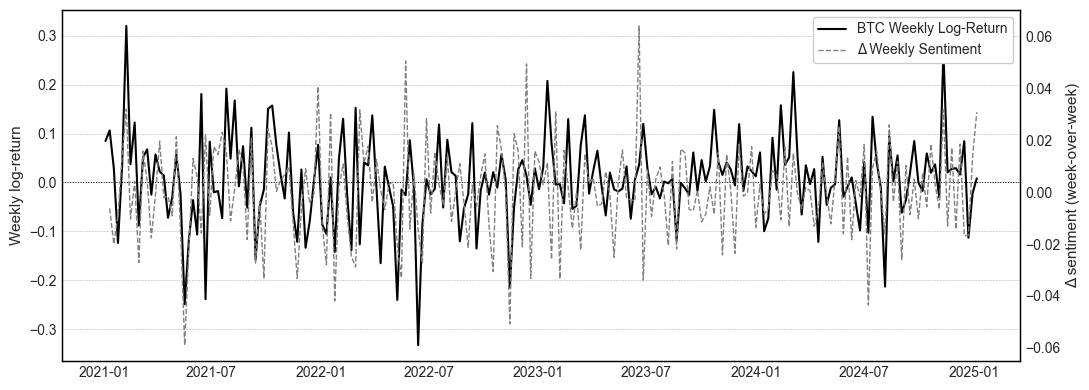

In [27]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax_ret = plt.subplots(figsize=(11, 4))
ax_sent = ax_ret.twinx()

# plot • returns on left axis  • Δ sentiment on right axis
ax_ret.plot(weekly.index, weekly['ret_w'],
            color='black', label='BTC Weekly Log-Return')
ax_sent.plot(weekly.index, weekly['d_sent'],
             color='gray', linestyle='--', linewidth=1.0, label='Δ Weekly Sentiment')

# axis labelling
ax_ret.set_ylabel('Weekly log-return', fontsize=11)
ax_sent.set_ylabel('Δ sentiment (week-over-week)', fontsize=11)

# reference lines
ax_ret.axhline(0, color='black',  linewidth=.7, linestyle=':')

ax_sent.spines['top'].set_color('black')
ax_sent.spines['right'].set_color('black')
ax_sent.spines['left'].set_color('black')
ax_sent.spines['bottom'].set_color('black')
ax_sent.grid(False) 
ax_ret.grid(True, axis="y", ls="--", lw=0.4, color="grey", alpha=0.6)
ax_ret.grid(False, which='major', axis='x')

# legend
lines1, labs1 = ax_ret.get_legend_handles_labels()
lines2, labs2 = ax_sent.get_legend_handles_labels()
ax_ret.legend(lines1+lines2, labs1+labs2, loc='upper right', frameon=True, framealpha=1)

plt.tight_layout()
plt.savefig("plot_VADER.png", dpi=300, bbox_inches="tight")
plt.show()

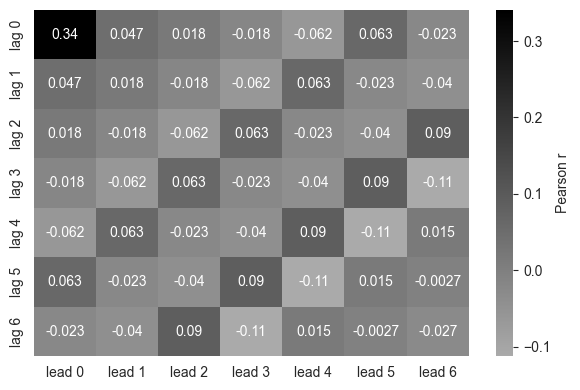

In [10]:
max_lag = 6
max_lead = 6
corr_mat = np.zeros((max_lag+1, max_lead+1))

for k in range(max_lag+1):                 # lag of sentiment
    for h in range(max_lead+1):            # lead of return
        x = weekly['d_sent'].shift(k)      # lag k
        y = weekly['ret_w'].shift(-h)      # lead h
        corr_mat[k, h] = x.corr(y)

heat = pd.DataFrame(corr_mat,
                    index=[f"lag {k}"  for k in range(max_lag+1)],
                    columns=[f"lead {h}" for h in range(max_lead+1)])

plt.figure(figsize=(6, 4))
sns.heatmap(heat, annot=True, cmap='binary', center=0,
            cbar_kws={'label': 'Pearson r'})

# plt.title('VADER Δ sentiment vs BTC returns\nlag–lead correlation map')
plt.tight_layout()
plt.savefig("plot_lagleadorr_with_stats.png", dpi=300, bbox_inches='tight')
plt.show()

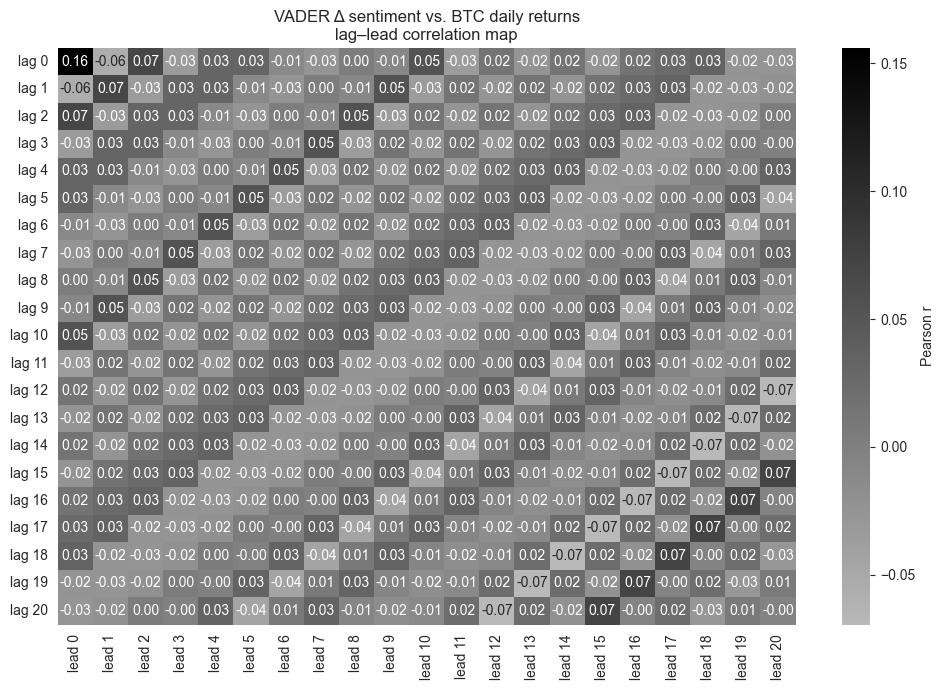

In [9]:
merged_daily = pd.DataFrame({
    'ret_d'  : daily_ret,                         # log-return (already daily)
    'sent_d' : merged['vader']                    # or 'finbert'
}).dropna()

merged_daily['d_sent'] = merged_daily['sent_d'].diff()
merged_daily = merged_daily.dropna()

# --- 2.  CORRELATION matrix, ±25 days ----------------------------------------
max_lag  = 20          # past sentiment influence on future returns
max_lead = 20          # future returns relative to past sentiment

corr_mat = np.empty((max_lag + 1, max_lead + 1))

for k in range(max_lag + 1):           # sentiment lag k  (k ≥ 0)
    x = merged_daily['d_sent'].shift(k)
    for h in range(max_lead + 1):      # return lead h   (h ≥ 0)
        y = merged_daily['ret_d'].shift(-h)
        corr_mat[k, h] = x.corr(y)

heat = pd.DataFrame(
    corr_mat,
    index   = [f"lag {k}"  for k in range(max_lag + 1)],
    columns = [f"lead {h}" for h in range(max_lead + 1)]
)

# --- 3.  PLOT ----------------------------------------------------------------
plt.figure(figsize=(10, 7))
sns.heatmap(
    heat,
    annot        = True,
    fmt          = ".2f",
    cmap         = "binary",   # diverging palettes (e.g. 'coolwarm') can be nicer
    center       = 0,
    cbar_kws     = {'label': 'Pearson r'}
)
plt.title('VADER Δ sentiment vs. BTC daily returns\nlag–lead correlation map')
plt.tight_layout()
plt.savefig("daily_lag_lead_corr_±25d.png", dpi=300, bbox_inches='tight')
plt.show()

In [104]:
weekly_lag = weekly.copy()
weekly_lag['d_sent_lag1'] = weekly_lag['d_sent'].shift(1)    # last week’s Δ sentiment
weekly_lag.dropna(inplace=True)

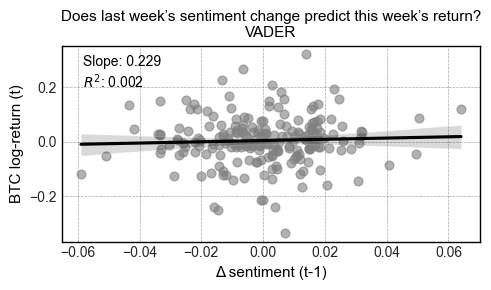

In [105]:
X = weekly_lag['d_sent_lag1']
y = weekly_lag['ret_w']
X = sm.add_constant(X)  # Add constant for intercept
model = sm.OLS(y, X).fit()

# Extract slope and R²
slope = model.params['d_sent_lag1']
r_squared = model.rsquared

# Plot the regression
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(5, 3))

sns.regplot(x='d_sent_lag1', y='ret_w', data=weekly_lag,
            scatter_kws=dict(alpha=0.6, s=40, color='gray'),
            line_kws=dict(color='black'), ax=ax)

# Annotate slope and R²
ax.text(0.05, 0.95, f"Slope: {slope:.3f}\n$R^2$: {r_squared:.3f}",
        transform=ax.transAxes, fontsize=10, verticalalignment='top', color='black')

# Axis labels
ax.set_xlabel('Δ sentiment (t-1)', fontsize=11, color='black')
ax.set_ylabel('BTC log-return (t)', fontsize=11, color='black')

# Spines and gridlines
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_color('black')

ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

ax.set_title('Does last week’s sentiment change predict this week’s return?\nVADER', fontsize=11, color='black')

plt.tight_layout()
plt.savefig("plot_vadercorr_with_stats.png", dpi=300)
plt.show()

In [ ]:
corr = weekly_lag['d_sent_lag1'].corr(weekly_lag['ret_w'])
print(f"ρ(Δsent_{'{t-1}'} ,  ret_{'{t}'})  =  {corr:.3f}")

In [28]:
weekly = pd.DataFrame({
    'ret_w'  : merged['return'].resample('W-MON').sum(),   # log-return for the week
    'sent_w' : merged['finbert'].resample('W-MON').mean()    # or 'finbert'
}).dropna()

weekly['d_sent'] = weekly['sent_w'].diff()     

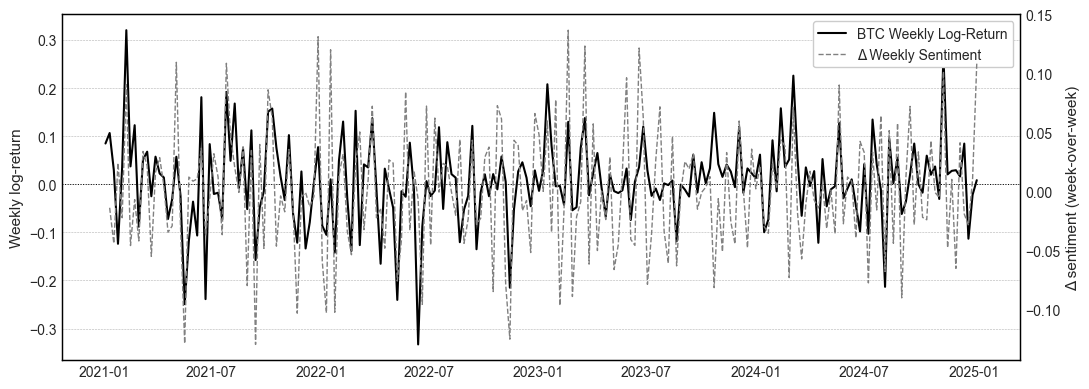

In [29]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax_ret = plt.subplots(figsize=(11, 4))
ax_sent = ax_ret.twinx()

# plot • returns on left axis  • Δ sentiment on right axis
ax_ret.plot(weekly.index, weekly['ret_w'],
            color='black', label='BTC Weekly Log-Return')
ax_sent.plot(weekly.index, weekly['d_sent'],
             color='gray', linestyle='--', linewidth=1.0, label='Δ Weekly Sentiment')

# axis labelling
ax_ret.set_ylabel('Weekly log-return', fontsize=11)
ax_sent.set_ylabel('Δ sentiment (week-over-week)', fontsize=11)

# reference lines
ax_ret.axhline(0, color='black',  linewidth=.7, linestyle=':')

ax_sent.spines['top'].set_color('black')
ax_sent.spines['right'].set_color('black')
ax_sent.spines['left'].set_color('black')
ax_sent.spines['bottom'].set_color('black')
ax_sent.grid(False) 
ax_ret.grid(True, axis="y", ls="--", lw=0.4, color="grey", alpha=0.6)
ax_ret.grid(False, which='major', axis='x')

# legend
lines1, labs1 = ax_ret.get_legend_handles_labels()
lines2, labs2 = ax_sent.get_legend_handles_labels()
ax_ret.legend(lines1+lines2, labs1+labs2, loc='upper right', frameon=True, framealpha=1)

plt.tight_layout()
plt.savefig("plot_FINERT.png", dpi=300)
plt.show()

In [95]:
weekly_lag = weekly.copy()
weekly_lag['d_sent_lag1'] = weekly_lag['d_sent'].shift(1)    # last week’s Δ sentiment
weekly_lag.dropna(inplace=True)

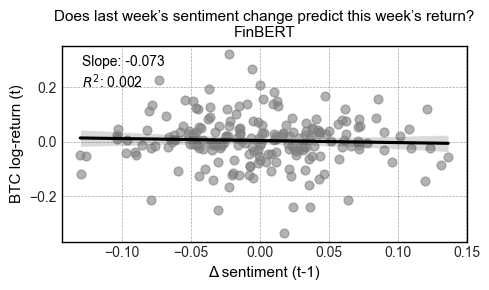

In [96]:
# Fit the regression model
X = weekly_lag['d_sent_lag1']
y = weekly_lag['ret_w']
X = sm.add_constant(X)  # Add constant for intercept
model = sm.OLS(y, X).fit()

# Extract slope and R²
slope = model.params['d_sent_lag1']
r_squared = model.rsquared

# Plot the regression
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(5, 3))

sns.regplot(x='d_sent_lag1', y='ret_w', data=weekly_lag,
            scatter_kws=dict(alpha=0.6, s=40, color='gray'),
            line_kws=dict(color='black'), ax=ax)

# Annotate slope and R²
ax.text(0.05, 0.95, f"Slope: {slope:.3f}\n$R^2$: {r_squared:.3f}",
        transform=ax.transAxes, fontsize=10, verticalalignment='top', color='black')

# Axis labels
ax.set_xlabel('Δ sentiment (t-1)', fontsize=11, color='black')
ax.set_ylabel('BTC log-return (t)', fontsize=11, color='black')

# Spines and gridlines
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_color('black')

ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

ax.set_title('Does last week’s sentiment change predict this week’s return?\nFinBERT', fontsize=11, color='black')

plt.tight_layout()
plt.savefig("plot_vadercorr_with_stats.png", dpi=300)
plt.show()

In [76]:
corr = weekly_lag['d_sent_lag1'].corr(weekly_lag['ret_w'])
print(f"ρ(Δsent_{'{t-1}'} ,  ret_{'{t}'})  =  {corr:.3f}")

ρ(Δsent_{t-1} ,  ret_{t})  =  0.097


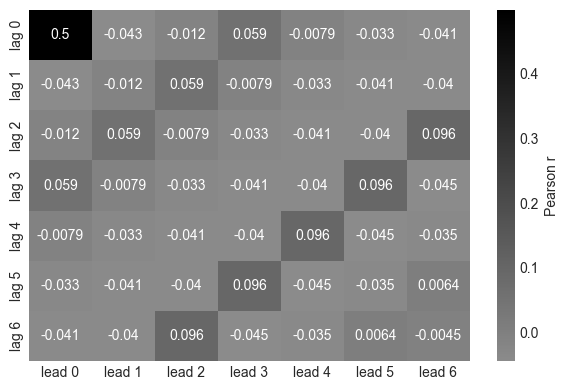

In [97]:
max_lag = 6
max_lead = 6
corr_mat = np.zeros((max_lag+1, max_lead+1))

for k in range(max_lag+1):                 # lag of sentiment
    for h in range(max_lead+1):            # lead of return
        x = weekly['d_sent'].shift(k)      # lag k
        y = weekly['ret_w'].shift(-h)      # lead h
        corr_mat[k, h] = x.corr(y)

heat = pd.DataFrame(corr_mat,
                    index=[f"lag {k}"  for k in range(max_lag+1)],
                    columns=[f"lead {h}" for h in range(max_lead+1)])

plt.figure(figsize=(6, 4))
sns.heatmap(heat, annot=True, cmap='binary', center=0,
            cbar_kws={'label': 'Pearson r'})

# plt.title('VADER Δ sentiment vs BTC returns\nlag–lead correlation map')
plt.tight_layout()
plt.savefig("plot_lagleadorr_with_stats.png", dpi=300, bbox_inches='tight')
plt.show()

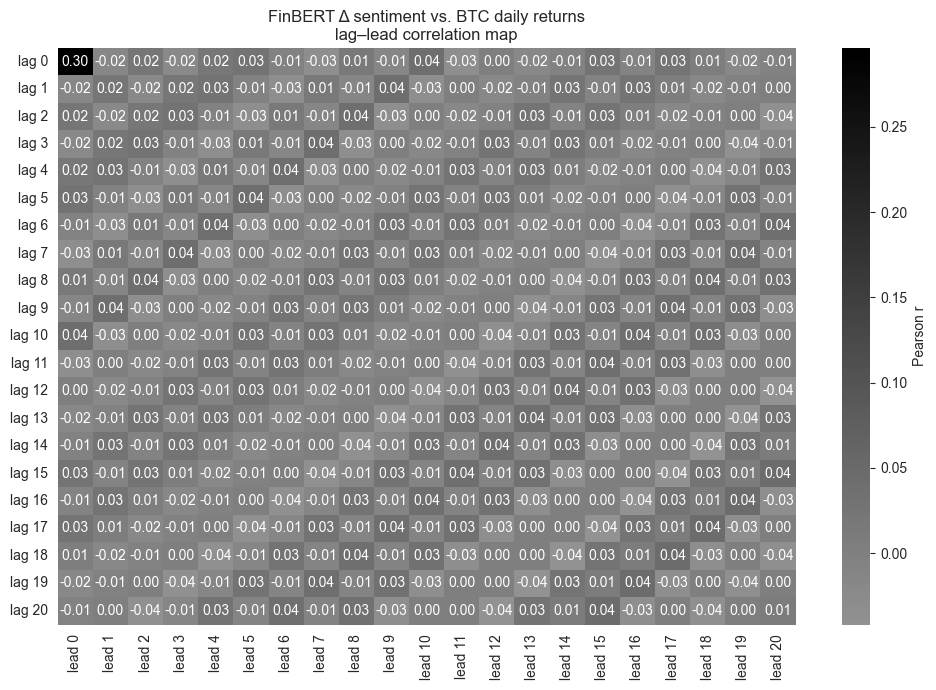

In [10]:
merged_daily = pd.DataFrame({
    'ret_d'  : daily_ret,                         # log-return (already daily)
    'sent_d' : merged['finbert']                    # or 'finbert'
}).dropna()

merged_daily['d_sent'] = merged_daily['sent_d'].diff()
merged_daily = merged_daily.dropna()

# --- 2.  CORRELATION matrix, ±25 days ----------------------------------------
max_lag  = 20          # past sentiment influence on future returns
max_lead = 20          # future returns relative to past sentiment

corr_mat = np.empty((max_lag + 1, max_lead + 1))

for k in range(max_lag + 1):           # sentiment lag k  (k ≥ 0)
    x = merged_daily['d_sent'].shift(k)
    for h in range(max_lead + 1):      # return lead h   (h ≥ 0)
        y = merged_daily['ret_d'].shift(-h)
        corr_mat[k, h] = x.corr(y)

heat = pd.DataFrame(
    corr_mat,
    index   = [f"lag {k}"  for k in range(max_lag + 1)],
    columns = [f"lead {h}" for h in range(max_lead + 1)]
)

# --- 3.  PLOT ----------------------------------------------------------------
plt.figure(figsize=(10, 7))
sns.heatmap(
    heat,
    annot        = True,
    fmt          = ".2f",
    cmap         = "binary",   # diverging palettes (e.g. 'coolwarm') can be nicer
    center       = 0,
    cbar_kws     = {'label': 'Pearson r'}
)
plt.title('FinBERT Δ sentiment vs. BTC daily returns\nlag–lead correlation map')
plt.tight_layout()
plt.savefig("daily_lag_lead_corr_±25d.png", dpi=300, bbox_inches='tight')
plt.show()

In [30]:
merged = pd.DataFrame({
    'return': daily_ret,
    'vader': df_v['daily_vader_sentiment'],
    'finbert': df_f['daily_finbert_score']
}).dropna()
weekly = pd.DataFrame({
    'ret_w': merged['return'].resample('W-MON').sum(),  # log-return for the week
    'sent_w': merged['vader'].resample('W-MON').mean()  # or 'finbert'
}).dropna()

weekly['d_sent'] = weekly['sent_w'].diff()  # Δ sentiment (this week – last week)

In [31]:
weekly = (merged                     # daily df: return, vader, finbert
          .resample('W-MON')         # use Friday as week-end
          .agg({'return': 'sum',     # sum daily log-returns → weekly return
                'vader' : 'mean',    # average sentiment over the week
                'finbert': 'mean'})
          .dropna())

weekly.rename(columns={'return': 'ret_w',
                       'vader' : 'vader_w',
                       'finbert': 'finbert_w'},
              inplace=True)

# --- 2. Week-over-week deltas ---------------------------------------
weekly['d_vader']   = weekly['vader_w'].diff()
weekly['d_finbert'] = weekly['finbert_w'].diff()

# --- 3. Standardise (z-score) each sentiment delta ------------------
weekly['z_vader']   = zscore(weekly['d_vader'].dropna())
weekly['z_finbert'] = zscore(weekly['d_finbert'].dropna())

# Align NaNs created by diff() / zscore()
weekly[['z_vader', 'z_finbert']] = weekly[['z_vader', 'z_finbert']].reindex(weekly.index)

# --- 4. Simple combined sentiment change (equal weight) -------------
weekly['d_comb'] = 0.5 * (weekly['z_vader'] + weekly['z_finbert'])

# Optional: standardise the combined series too
weekly['z_comb'] = zscore(weekly['d_comb'].dropna())
weekly['z_comb'] = weekly['z_comb'].reindex(weekly.index)

# --- 5. Quick check --------------------------------------------------
print(weekly.head())

               ret_w   vader_w  finbert_w   d_vader  d_finbert   z_vader  \
date                                                                       
2021-01-04  0.084743  0.221923  -0.102517       NaN        NaN       NaN   
2021-01-11  0.106551  0.215681  -0.116461 -0.006243  -0.013944 -0.346361   
2021-01-18  0.029461  0.195701  -0.160627 -0.019980  -0.044166 -1.101623   
2021-01-25 -0.123749  0.186955  -0.136705 -0.008745   0.023923 -0.483957   
2021-02-01  0.035534  0.200837  -0.159117  0.013881  -0.022413  0.760010   

            z_finbert    d_comb    z_comb  
date                                       
2021-01-04        NaN       NaN       NaN  
2021-01-11  -0.269744 -0.308053 -0.335729  
2021-01-18  -0.846476 -0.974050 -1.061560  
2021-01-25   0.452887 -0.015535 -0.016931  
2021-02-01  -0.431349  0.164331  0.179094  


In [32]:
weekly = weekly.dropna(subset=['d_vader', 'd_finbert'])

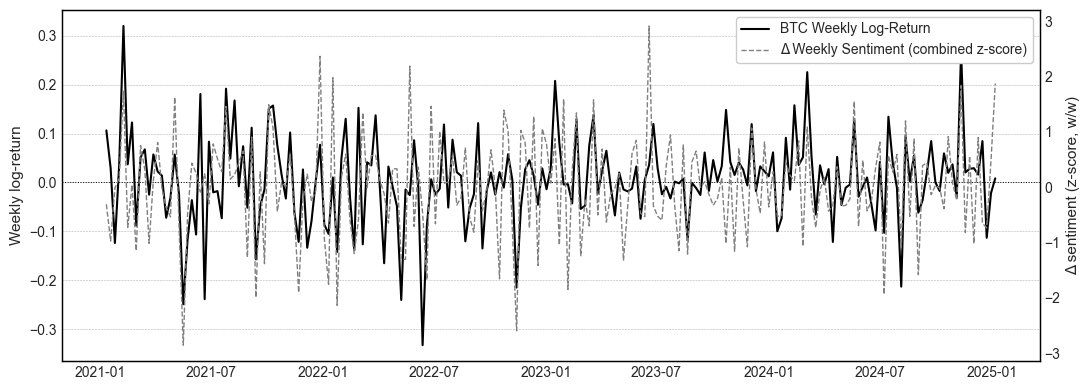

In [33]:
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax_ret = plt.subplots(figsize=(11, 4))
ax_sent = ax_ret.twinx()

# --- lines -----------------------------------------------------------
ax_ret.plot(weekly.index, weekly['ret_w'],
            color='black', label='BTC Weekly Log-Return')

ax_sent.plot(weekly.index, weekly['d_comb'],
             color='gray', linestyle='--', linewidth=1.0,
             label='Δ Weekly Sentiment (combined z-score)')

# --- axes & grid -----------------------------------------------------
ax_ret.set_ylabel('Weekly log-return', fontsize=11)
ax_sent.set_ylabel('Δ sentiment (z-score, w/w)', fontsize=11)

ax_ret.axhline(0, color='black', linewidth=.7, linestyle=':')
ax_sent.grid(False)
ax_ret.grid(True, axis="y", ls="--", lw=0.4, color="grey", alpha=0.6)
ax_ret.grid(False, which='major', axis='x')

for spine in ['top', 'right', 'left', 'bottom']:
    ax_sent.spines[spine].set_color('black')

# --- legend ----------------------------------------------------------
h1, l1 = ax_ret.get_legend_handles_labels()
h2, l2 = ax_sent.get_legend_handles_labels()
ax_ret.legend(h1+h2, l1+l2, loc='upper right', frameon=True, framealpha=1)

plt.tight_layout()
plt.savefig('plot_combined_sent.png', dpi=300)
plt.show()

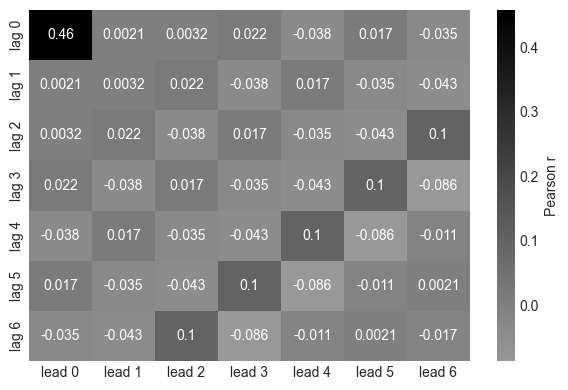

In [49]:
max_lag  = 6          # sentiment lags (weeks back)
max_lead = 6          # return leads (weeks ahead)

corr_mat = np.zeros((max_lag+1, max_lead+1))

for k in range(max_lag+1):
    for h in range(max_lead+1):
        x = weekly['d_comb'].shift(k)   # lag k
        y = weekly['ret_w'].shift(-h)   # lead h
        corr_mat[k, h] = x.corr(y)

heat = pd.DataFrame(corr_mat,
                    index=[f'lag {k}'  for k in range(max_lag+1)],
                    columns=[f'lead {h}' for h in range(max_lead+1)])

plt.figure(figsize=(6, 4))
sns.heatmap(heat, annot=True,
            cmap='binary', center=0,
            cbar_kws={'label': 'Pearson r'})


# plt.title('Combined Δ-sentiment vs BTC returns\nLag–Lead Correlation Map')
plt.tight_layout()
plt.savefig('heat_combined_sent.png', dpi=300, bbox_inches='tight')
plt.show()

In [58]:
corr_lag1 = weekly['d_comb'].shift(1).corr(weekly['ret_w'])
print(f'ρ_lag1 = {corr_lag1:.4f}')

ρ_lag1 = 0.0021


In [59]:
print(weekly[['d_vader','d_finbert']].corr())      # raw Δ correlation
print(weekly[['z_vader','z_finbert']].corr())      # z-score correlation

            d_vader  d_finbert
d_vader    1.000000   0.683848
d_finbert  0.683848   1.000000
            z_vader  z_finbert
z_vader    1.000000   0.683848
z_finbert  0.683848   1.000000


explore daily

In [15]:
daily = pd.DataFrame({
        'ret_d' : daily_ret,                        # daily log-return
        'vader' : df_v['daily_vader_sentiment'],
        'finbert': df_f['daily_finbert_score']
    }).dropna()

In [32]:
sent_col = 'vader'

In [33]:
daily['d_sent'] = daily[sent_col].diff()
daily = daily.dropna(subset=['d_sent'])   

In [34]:
max_lag  = 5     # how many days sentiment lags
max_lead = 5     # how many days returns lead
corr_mat = np.zeros((max_lag+1, max_lead+1))

for k in range(max_lag+1):                 # lag of sentiment
    for h in range(max_lead+1):            # lead of return
        x = daily['d_sent'].shift(k)       # sentiment(t-k)
        y = daily['ret_d'].shift(-h)       # return(t+h)
        corr_mat[k, h] = x.corr(y)

heat = pd.DataFrame(corr_mat,
                    index=[f'lag {k}d'  for k in range(max_lag+1)],
                    columns=[f'lead {h}d' for h in range(max_lead+1)])

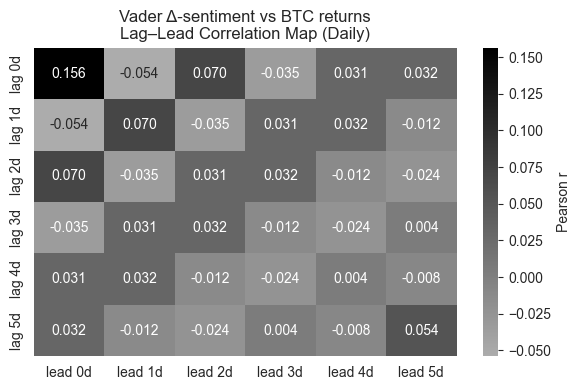

In [35]:
plt.figure(figsize=(6, 4))
sns.heatmap(heat, annot=True, fmt='.3f',
            cmap='binary', center=0,
            cbar_kws={'label': 'Pearson r'})

plt.title(f'{sent_col.capitalize()} Δ-sentiment vs BTC returns\nLag–Lead Correlation Map (Daily)')
plt.tight_layout()
plt.savefig(f'heat_{sent_col}_daily.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
daily['d_sent_lag1'] = daily['d_sent'].shift(1)
daily_lag = daily.dropna(subset=['d_sent_lag1', 'ret_d']).copy()

In [37]:
X = sm.add_constant(daily_lag['d_sent_lag1'])
y = daily_lag['ret_d']
model = sm.OLS(y, X).fit()

slope     = model.params['d_sent_lag1']
r_squared = model.rsquared

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  ret_d   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.258
Date:                Sun, 01 Jun 2025   Prob (F-statistic):             0.0392
Time:                        16:34:46   Log-Likelihood:                 2934.9
No. Observations:                1454   AIC:                            -5866.
Df Residuals:                    1452   BIC:                            -5855.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0006      0.001      0.704      

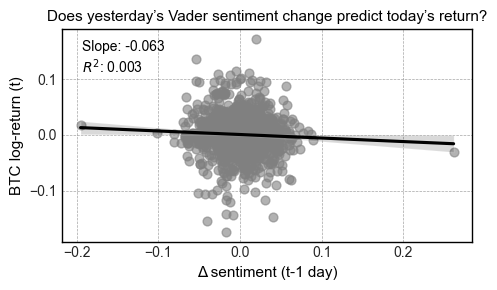

In [38]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(5, 3))

sns.regplot(x='d_sent_lag1', y='ret_d', data=daily_lag,
            scatter_kws=dict(alpha=0.6, s=40, color='gray'),
            line_kws=dict(color='black'), ax=ax)

ax.text(0.05, 0.95,
        f"Slope: {slope:.3f}\n$R^2$: {r_squared:.3f}",
        transform=ax.transAxes, fontsize=10,
        verticalalignment='top', color='black')

ax.set_xlabel('Δ sentiment (t-1 day)', fontsize=11, color='black')
ax.set_ylabel('BTC log-return (t)',  fontsize=11, color='black')

for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_color('black')

ax.grid(True, which='major', linestyle='--',
        linewidth=0.5, color='gray', alpha=0.7)

ax.set_title(f"Does yesterday’s {sent_col.capitalize()} sentiment change "
             "predict today’s return?", fontsize=11, color='black')

plt.tight_layout()
plt.savefig(f"scatter_reg_{sent_col}_daily.png", dpi=300)
plt.show()

Explore all google trend files

In [35]:
folder = r"C:\Users\Leo Hubmann\Desktop\thesis\data\gtrends_data\google_trends_output_daily_single"

csv_files = glob.glob(os.path.join(folder, "*.csv"))

all_dfs = []

for file in csv_files:
    
    df = pd.read_csv(file, usecols=[0, 1], low_memory=False)
    
    df.columns = ['Date', 'Trend']
    df['Date'] = pd.to_datetime(df['Date'])
    
    search_term = os.path.basename(file).split('_trend_daily')[0]
    df['Search Term'] = search_term
    
    all_dfs.append(df)

combined = pd.concat(all_dfs)

pivoted = combined.pivot(index='Date', columns='Search Term', values='Trend')

pivoted_smoothed = pivoted.rolling(window=7, min_periods=1).mean()
trend_data = pivoted_smoothed

In [36]:
folder = r"C:\Users\Leo Hubmann\Desktop\thesis\data\gtrends_data\google_trends_output_daily_single"

csv_files = glob.glob(os.path.join(folder, "*.csv"))

all_dfs = []

for file in csv_files:
    
    df = pd.read_csv(file, usecols=[0, 1], low_memory=False)
    
    df.columns = ['Date', 'Trend']
    df['Date'] = pd.to_datetime(df['Date'])
    
    search_term = os.path.basename(file).split('_trend_daily')[0]
    df['Search Term'] = search_term
    
    all_dfs.append(df)

combined = pd.concat(all_dfs)

pivoted = combined.pivot(index='Date', columns='Search Term', values='Trend')

pivoted_smoothed = pivoted.rolling(window=7, min_periods=1).mean()
trend_data = pivoted_smoothed

btc_path = r"C:\Users\Leo Hubmann\Desktop\thesis\data\price_data\bitcoin_2021_2024.csv"
btc_df = pd.read_csv(btc_path, usecols=['date', 'close'])
btc_df.columns = ['date', 'close']
btc_df['date'] = pd.to_datetime(btc_df['date'])
btc_df.set_index('date', inplace=True)

btc_df = btc_df.loc['2021-01-01':'2024-12-31']

btc_smooth = btc_df['close'].rolling(window=7, min_periods=1).mean()



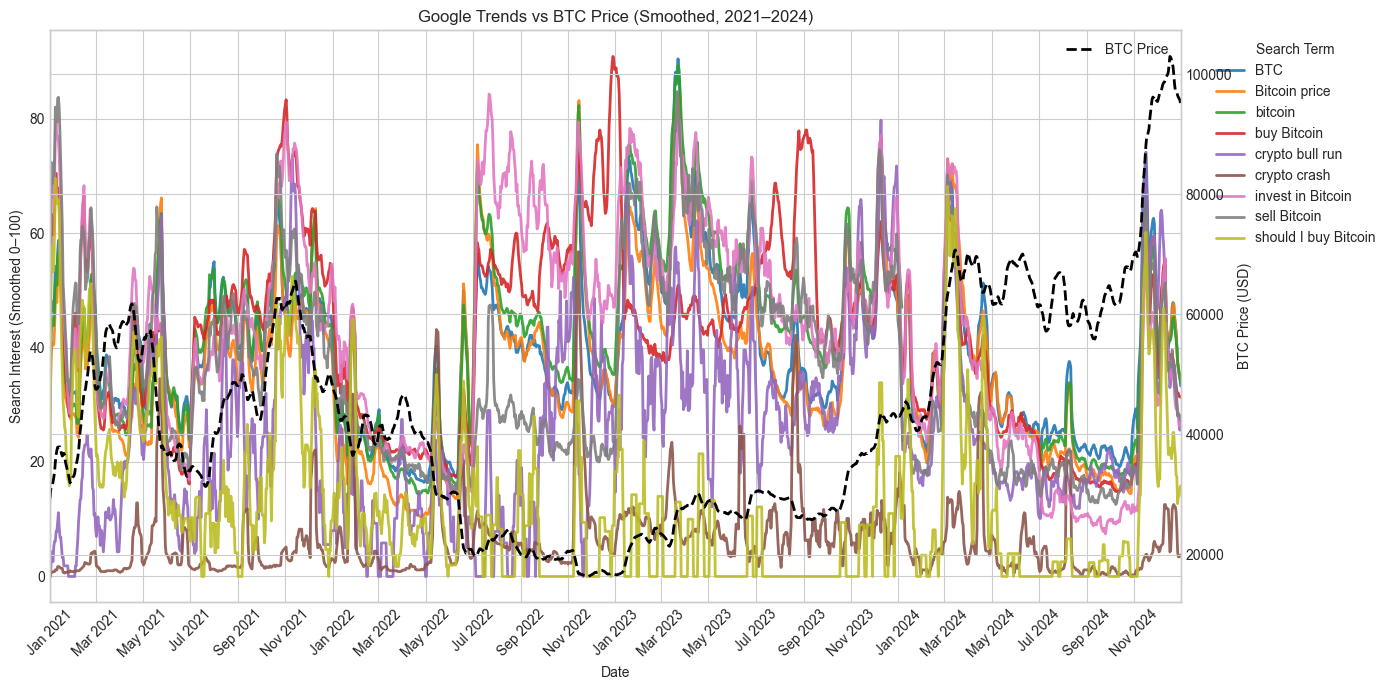

In [37]:
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot search trends
trend_data.plot(ax=ax1, linewidth=2, alpha=0.9)
ax1.set_ylabel("Search Interest (Smoothed 0–100)")
ax1.set_xlabel("Date")
ax1.legend(title="Search Term", bbox_to_anchor=(1.02, 1), loc='upper left')

# Format x-axis to show months
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Plot BTC price on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(btc_smooth.index, btc_smooth, color='black', linestyle='--', linewidth=2, label='BTC Price')
ax2.set_ylabel("BTC Price (USD)")
ax2.legend(loc='upper right')

plt.title("Google Trends vs BTC Price (Smoothed, 2021–2024)")
plt.tight_layout()
plt.show()

In [38]:
positive_terms = [
    "buy Bitcoin", "crypto bull run", "invest in Bitcoin",
    "should I buy Bitcoin", "Bitcoin price", "bitcoin", "BTC"
]
negative_terms = [
    "sell Bitcoin", "crypto crash"
]

In [39]:
folder = r"C:\Users\Leo Hubmann\Desktop\thesis\data\gtrends_data\google_trends_output_daily_single"
csv_files = glob.glob(os.path.join(folder, "*.csv"))

series = {}
for f in csv_files:
    df = pd.read_csv(f, usecols=[0, 1], parse_dates=[0])
    term = os.path.basename(f).split('_trend_daily')[0]
    df.columns = ['Date', term]
    series[term] = df.set_index('Date')[term]

gtr_raw = pd.concat(series, axis=1)

# keep analysis window & 7-day moving average
gtr_smoothed = (
    gtr_raw
      .loc['2021-01-01':'2024-12-31']
      .rolling(7, min_periods=1)
      .mean()
)

In [40]:
pos_index = gtr_smoothed[positive_terms].mean(axis=1)
neg_index = gtr_smoothed[negative_terms].mean(axis=1)

# resample to weekly (Monday) to de-noise further
pos_w = pos_index.resample('W-MON').mean()
neg_w = neg_index.resample('W-MON').mean()

# scale 0–100 ⇒ –100…+100 for net sentiment
net_sent =  (pos_w - neg_w)

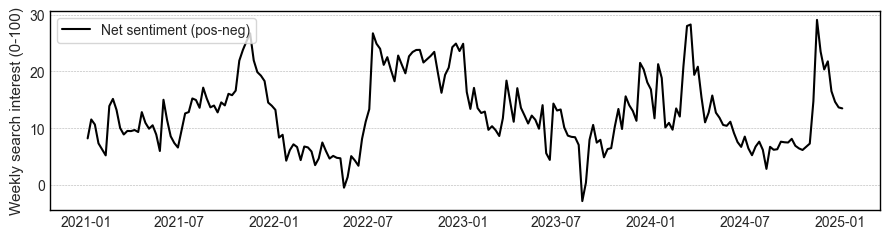

In [41]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(9,2.5))

ax.plot(net_sent.index, net_sent, label='Net sentiment (pos-neg)', color='black')

ax.set_ylabel('Weekly search interest (0-100)', fontsize=11)

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1,7)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.tick_params(axis='x', rotation=0)

ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

ax.grid(True, axis="y", ls="--", lw=0.4, color="grey", alpha=0.6)
ax.grid(False, which='major', axis='x')

ax.legend(frameon=True)

ax.legend(frameon=True, loc='upper left')
plt.tight_layout()
plt.savefig('figure_gtrends_sentiment.png', dpi=300, bbox_inches="tight")
plt.show()

(<Figure size 900x250 with 1 Axes>, <Axes: >)

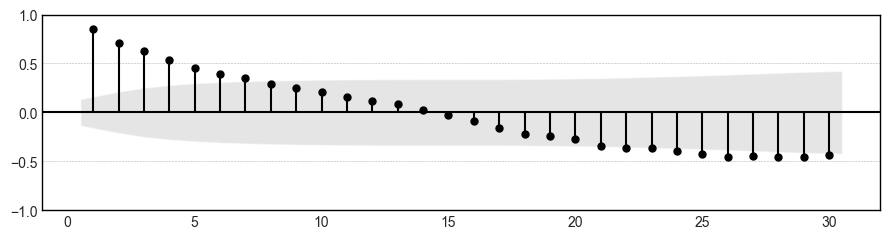

In [104]:
plot_acf_grey(net_sent, lags=30, ci_colour="silver", ci_alpha=0.4, filename="googlacf.png")

In [42]:
# weekly already contains ret_w, d_vader, d_finbert, etc.

# 1) join the smoothed weekly Google index
weekly = weekly.join(net_sent.rename('gtrend_w'), how='inner')

# 2) week-over-week change
weekly['d_gtrend'] = weekly['gtrend_w'].diff()

# # drop the first NaN row (optional)
# weekly = weekly.dropna(subset=['d_gtrend'])

print(weekly[['gtrend_w', 'd_gtrend']].head())

             gtrend_w  d_gtrend
2021-01-11  11.547959       NaN
2021-01-18  10.660350 -0.887609
2021-01-25   7.342566 -3.317784
2021-02-01   6.274052 -1.068513
2021-02-08   5.227405 -1.046647


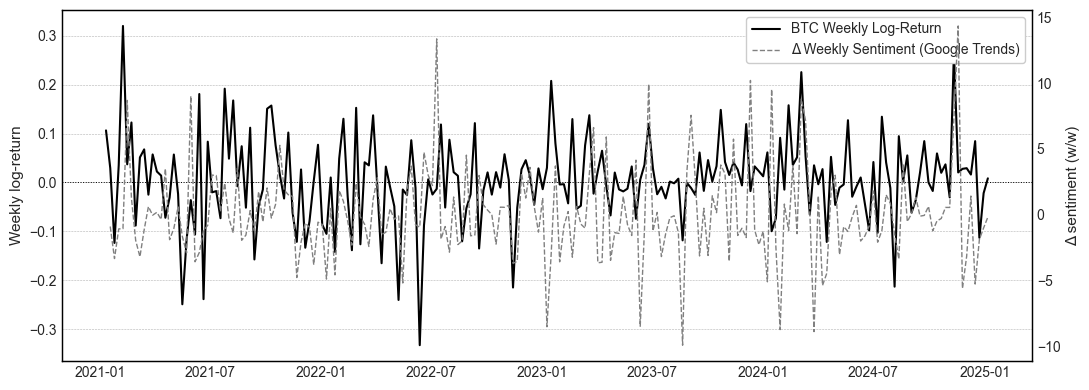

In [47]:
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax_ret = plt.subplots(figsize=(11, 4))
ax_sent = ax_ret.twinx()

ax_ret.plot(weekly.index, weekly['ret_w'],
            color='black', label='BTC Weekly Log-Return')

ax_sent.plot(weekly.index, weekly['d_gtrend'],
             color='gray', linestyle='--', linewidth=1.0,
             label='Δ Weekly Sentiment (Google Trends)')

ax_ret.set_ylabel('Weekly log-return', fontsize=11)
ax_sent.set_ylabel('Δ sentiment (w/w)', fontsize=11)

ax_ret.axhline(0, color='black', linewidth=.7, linestyle=':')
ax_sent.grid(False)
ax_ret.grid(True, axis="y", ls="--", lw=0.4, color="grey", alpha=0.6)
ax_ret.grid(False, which='major', axis='x')

for spine in ['top', 'right', 'left', 'bottom']:
    ax_sent.spines[spine].set_color('black')

h1, l1 = ax_ret.get_legend_handles_labels()
h2, l2 = ax_sent.get_legend_handles_labels()
ax_ret.legend(h1+h2, l1+l2, loc='upper right', frameon=True, framealpha=1)



plt.tight_layout()
plt.savefig('plot_gtrend_sent.png', dpi=300, bbox_inches="tight")
plt.show()

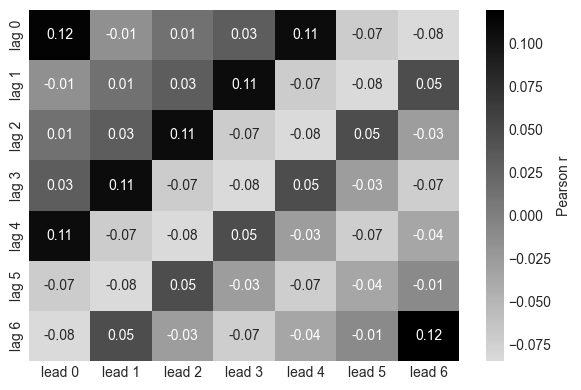

In [68]:
max_lag  = 6
max_lead = 6
corr_mat = np.zeros((max_lag+1, max_lead+1))

for k in range(max_lag+1):      # lag of sentiment
    for h in range(max_lead+1): # lead of return
        x = weekly['d_gtrend'].shift(k)
        y = weekly['ret_w'].shift(-h)
        corr_mat[k, h] = x.corr(y)

heat = pd.DataFrame(corr_mat,
                    index=[f'lag {k}'  for k in range(max_lag+1)],
                    columns=[f'lead {h}' for h in range(max_lead+1)])

plt.figure(figsize=(6, 4))
sns.heatmap(heat, annot=True, fmt='.2f',
            cmap='binary', center=0,
            cbar_kws={'label': 'Pearson r'})

# plt.title('Google Trends Δ-sentiment vs BTC returns\nLag–Lead Correlation Map')
plt.tight_layout()
plt.savefig('heat_gtrend_sent.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# ------------------------------------------------------------------
# a)  7-day smoothed daily indices (already created)
pos_index = gtr_smoothed[positive_terms].mean(axis=1)
neg_index = gtr_smoothed[negative_terms].mean(axis=1)

# b)  scale 0-100  →  –100 … +100  (optional but keeps "buy vs sell" intuitive)
net_sent = (pos_index - neg_index)
#   or: net_sent = 2*(pos_index - neg_index)/100        # if you prefer –2 … +2

# c)  daily Δ-sentiment
d_gtrend = net_sent.diff().dropna()      # first difference


In [15]:
df_daily = pd.DataFrame({
    'ret_d'    : daily_ret,   # daily log-return of BTC
    'd_gtrend' : d_gtrend
}).dropna()                   # keep common dates only


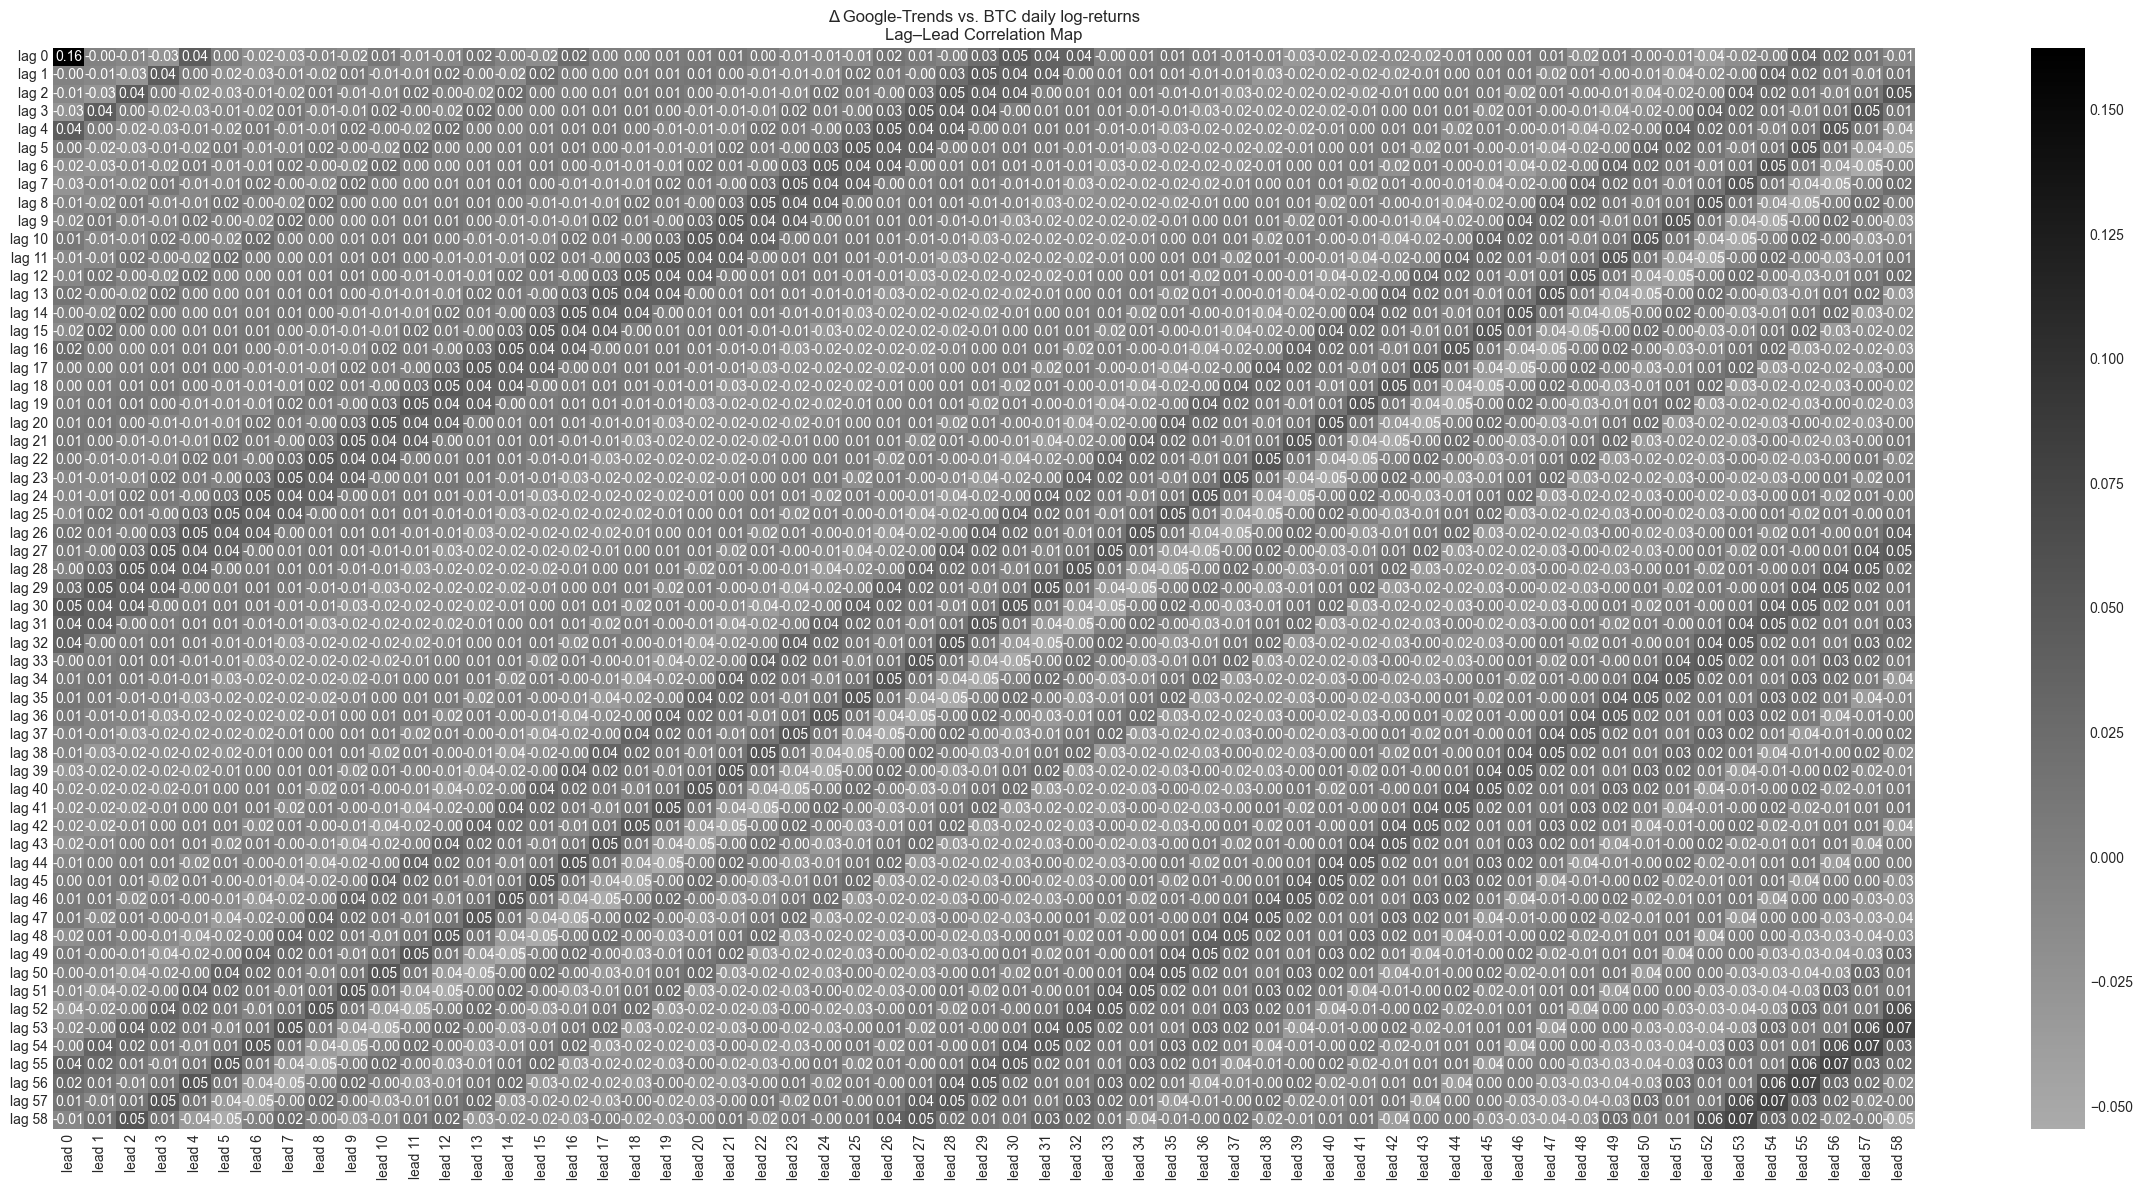

In [72]:
max_lag  = 58        # sentiment k days in the past
max_lead = 58        # return  h days in the future

corr_mat = np.empty((max_lag + 1, max_lead + 1))

for k in range(max_lag + 1):          # lag of sentiment
    x = df_daily['d_gtrend'].shift(k)
    for h in range(max_lead + 1):     # lead of return
        y = df_daily['ret_d'].shift(-h)
        corr_mat[k, h] = x.corr(y)

heat = pd.DataFrame(
    corr_mat,
    index   = [f"lag {k}"  for k in range(max_lag + 1)],
    columns = [f"lead {h}" for h in range(max_lead + 1)]
)

plt.figure(figsize=(24, 12))
sns.heatmap(
    heat,
    annot        = True,
    fmt          = ".2f",
    cmap         = "binary",     # try 'vlag' or 'RdBu_r' for diverging colour
    center       = 0
    # cbar_kws     = {'label': 'Pearson r'}
)
plt.title('Δ Google-Trends vs. BTC daily log-returns\nLag–Lead Correlation Map')
plt.tight_layout()
plt.savefig('heat_gtrend_daily.png', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
btc_returns = btc_df['close'].pct_change().dropna() * 100  # in %

avg_trend = pivoted.mean(axis=1)

avg_trend_smooth = avg_trend.rolling(window=7, min_periods=1).mean()

aligned = pd.DataFrame({
    'return': btc_returns,
    'trend': avg_trend_smooth
}).dropna()

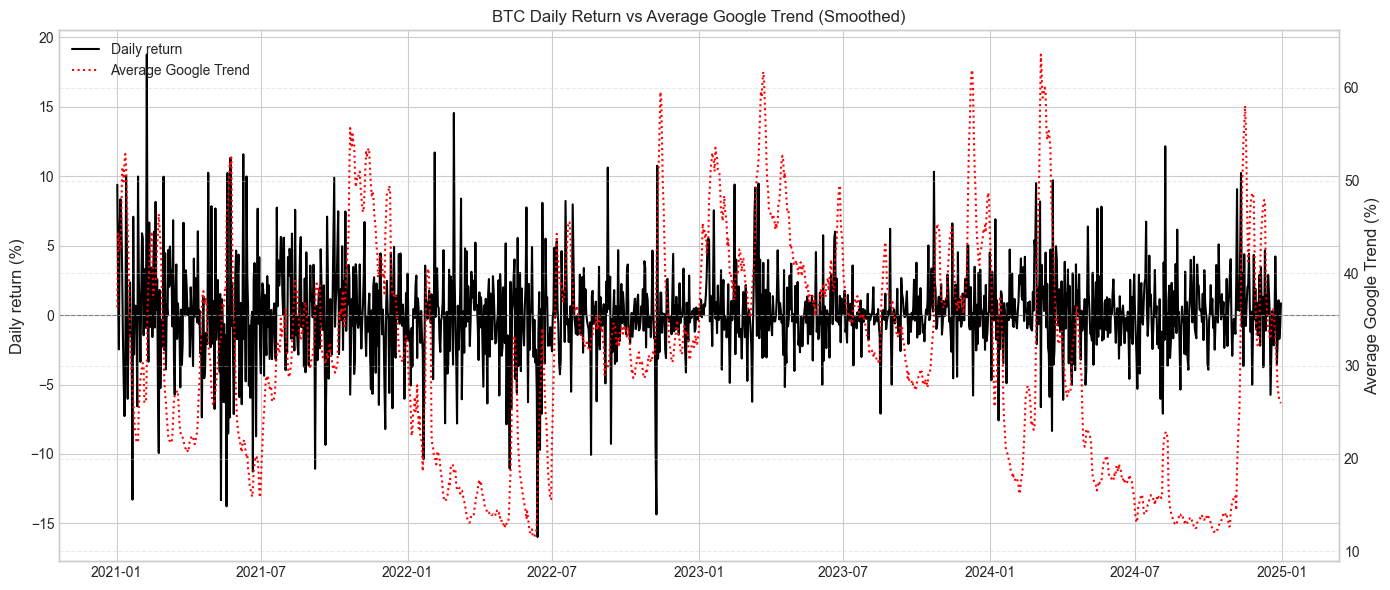

In [39]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# BTC return
ax1.plot(aligned.index, aligned['return'], color='black', label='Daily return')
ax1.set_ylabel("Daily return (%)", fontsize=12)
ax1.tick_params(axis='y')
ax1.axhline(0, color='gray', linestyle='--', linewidth=0.8)

# Trend on second y-axis
ax2 = ax1.twinx()
ax2.plot(aligned.index, aligned['trend'], color='red', linestyle=':', label='Average Google Trend')
ax2.set_ylabel("Average Google Trend (%)", fontsize=12)
ax2.tick_params(axis='y')

# Legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Formatting
plt.title("BTC Daily Return vs Average Google Trend (Smoothed)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Weekly

In [42]:
positive_terms = [
    "buy Bitcoin", "crypto bull run", "invest in Bitcoin", "Bitcoin price", "should I buy Bitcoin"
]

negative_terms = [
    "sell Bitcoin", "crypto crash"  # could be neutral/uncertain
]

def classify_term(term):
    if term in positive_terms:
        return 1
    elif term in negative_terms:
        return -1
    else:
        return 0  # neutral or unknown

combined['Sentiment Tag'] = combined['Search Term'].apply(classify_term)

combined['Weighted'] = combined['Trend'] * combined['Sentiment Tag']

# Pivot to time series
daily_sentiment_index = combined.groupby('Date')['Weighted'].mean()

weekly_sentiment = daily_sentiment_index.resample('W').mean().shift(1)


In [43]:
btc_weekly = btc_df['close'].resample('W').last()
btc_weekly_return = btc_weekly.pct_change().shift(-1) * 100  # forward return

trend_weekly = avg_trend_smooth.resample('W').mean()

weekly_combined = pd.DataFrame({
    'return': btc_weekly_return,
    'sentiment_lagged': weekly_sentiment
}).dropna()

# weekly_combined = pd.DataFrame({
#     'return': btc_weekly_return,
#     'sentiment_lagged': trend_weekly.shift(1)  # use previous week's average
# }).dropna()

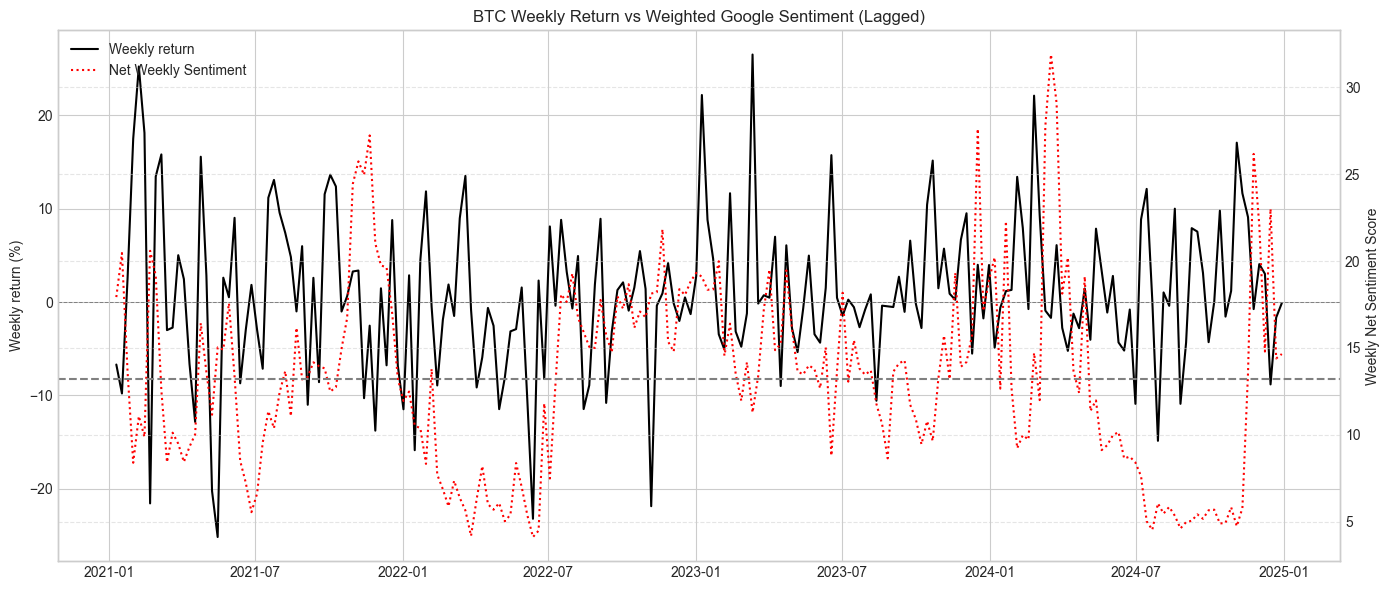

In [48]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot return
ax1.plot(weekly_combined.index, weekly_combined['return'], color='black', label='Weekly return')
ax1.set_ylabel("Weekly return (%)")
ax1.axhline(0, color='gray', linestyle='--', linewidth=0.7)

# Plot sentiment
ax2 = ax1.twinx()
#ax2.plot(weekly_combined.index, weekly_combined['sentiment_lagged'], color='red', linestyle=':', label='Avg Google Trend')
ax2.plot(weekly_combined.index, weekly_combined['sentiment_lagged'], 
         color='red', linestyle=':', label='Net Weekly Sentiment')
ax2.set_ylabel("Weekly Net Sentiment Score")
#ax2.set_ylabel("Weekly avg Google Trend (%)")

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title("BTC Weekly Return vs Weighted Google Sentiment (Lagged)")
#plt.title("BTC Weekly Return vs Avg Weekly Google Trend (Lagged)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [46]:
weekly_combined.corr()

return  sentiment_lagged
return            1.000000         -0.040567
sentiment_lagged -0.040567          1.000000

In [13]:
positive_terms = [
    "buy Bitcoin", "crypto bull run", "invest in Bitcoin", "Bitcoin price", "should I buy Bitcoin"
]

negative_terms = [
    "sell Bitcoin", "crypto crash"  # could be neutral/uncertain
]

def classify_term(term):
    if term in positive_terms:
        return 1
    elif term in negative_terms:
        return -1
    else:
        return 0  # neutral or unknown

# Assign sentiment tags
combined['Sentiment Tag'] = combined['Search Term'].apply(classify_term)

# Calculate weighted sentiment
combined['Weighted'] = combined['Trend'] * combined['Sentiment Tag']

# Aggregate sentiment into a single line
daily_sentiment_index = combined.groupby('Date')['Weighted'].sum()

# Optional: Resample to weekly sentiment
weekly_sentiment = daily_sentiment_index.resample('W').mean().shift(1)

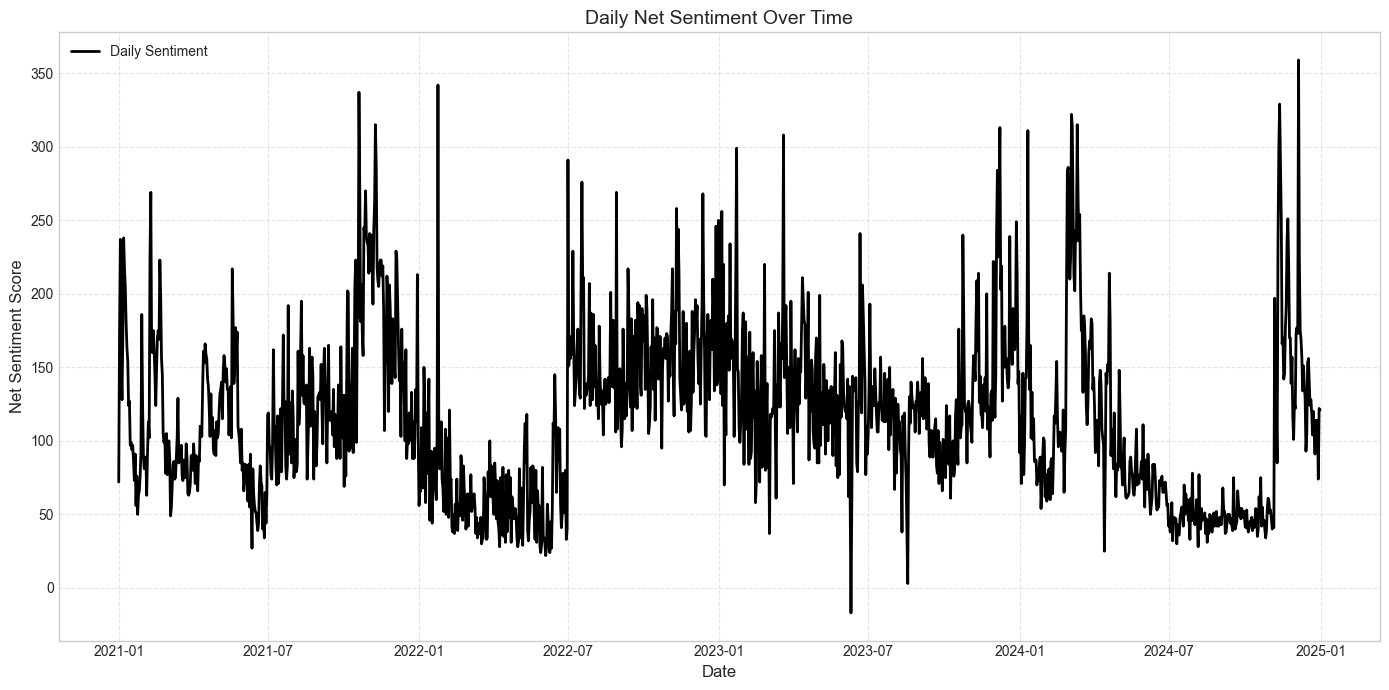

In [14]:
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the sentiment data
ax.plot(daily_sentiment_index.index, daily_sentiment_index, color='black', linewidth=2, label='Daily Sentiment')

# Formatting
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Net Sentiment Score", fontsize=12)
ax.set_title("Daily Net Sentiment Over Time", fontsize=14)
ax.legend(loc='upper left')
ax.grid(True, linestyle='--', alpha=0.5)

# Format x-axis to show months
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
# plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

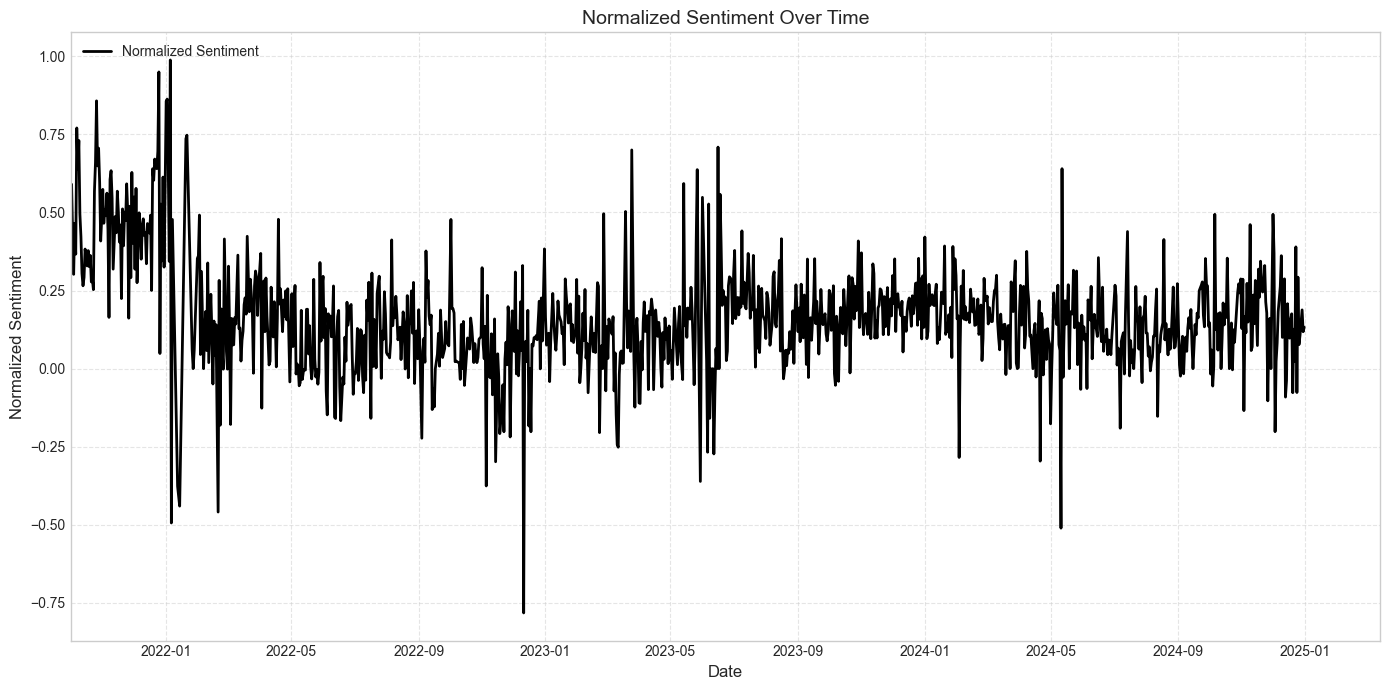

In [79]:
file_path = r'C:\Users\Leo Hubmann\Desktop\BachelorThesis_data\EODHD\eod_sentiment_btc.json'
data = pd.read_json(file_path)

# Normalize the data structure
df = pd.json_normalize(data['BTC-USD.CC'])

# Convert date to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Plot the time series
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(df.index, df['normalized'], color='black', linewidth=2, label='Normalized Sentiment')

# Formatting
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Normalized Sentiment", fontsize=12)
ax.set_title("Normalized Sentiment Over Time", fontsize=14)
ax.legend(loc='upper left')
ax.grid(True, linestyle='--', alpha=0.5)

# Set x-axis limits to start from January 1, 2021
ax.set_xlim(left=pd.to_datetime('2021-10-01'))

# # Format x-axis to show months
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
# plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

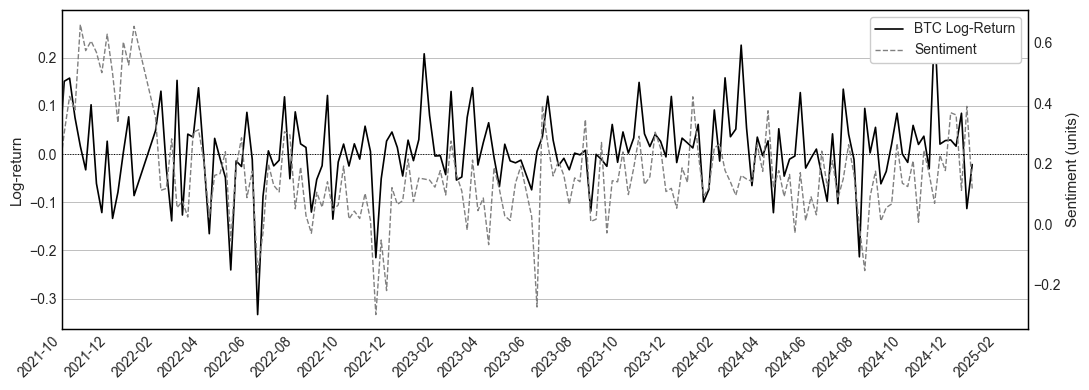

In [83]:
sent_series = df['normalized']          # EOD sentiment       (D)

freq = 'W-MON'                            # <-- EDIT this line

# -------------------------------------------------------------------
# 2)  aggregate returns to the same frequency
# -------------------------------------------------------------------
ret_series = (
    daily_ret
      .resample(freq)
      .sum()                              # summing log-returns ⇒ period log-return
)

# -------------------------------------------------------------------
# 3)  align & drop NaNs
# -------------------------------------------------------------------
data = (
    pd.concat({'ret': ret_series, 'sent': sent_series}, axis=1)
      .dropna()
)

# -------------------------------------------------------------------
# 4)  plot
# -------------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax_ret = plt.subplots(figsize=(11, 4))
ax_sent     = ax_ret.twinx()

# --- returns line (left axis) --------------------------------------
ax_ret.plot(
    data.index, data['ret'],
    color='black', linewidth=1.2, label='BTC Log-Return'
)

# --- sentiment line (right axis) -----------------------------------
ax_sent.plot(
    data.index, data['sent'],
    color='gray', linestyle='--', linewidth=1.0,
    label='Sentiment'
)

ax_sent.set_xlim(left=pd.to_datetime('2021-10-01'))
ax_ret.set_xlim(left=pd.to_datetime('2021-10-01'))


# --- axes formatting ------------------------------------------------
ax_ret.set_ylabel('Log-return',                fontsize=11)
ax_sent.set_ylabel('Sentiment (units)',        fontsize=11)

ax_ret.axhline(0, color='black', linewidth=.7, linestyle=':')
ax_sent.grid(False)
ax_ret.grid(True, axis='y', linewidth=0.5, color='grey', alpha=0.7)
ax_ret.grid(False, axis='x')

# black spines on right axis for consistency
for s in ['top', 'right', 'left', 'bottom']:
    ax_sent.spines[s].set_color('black')

# x-axis ticks every two months (change if freq != weekly)
ax_ret.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax_ret.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax_ret.xaxis.get_majorticklabels(), rotation=45, ha='right')

# --- legend ---------------------------------------------------------
h1, l1 = ax_ret.get_legend_handles_labels()
h2, l2 = ax_sent.get_legend_handles_labels()
ax_ret.legend(h1 + h2, l1 + l2,
              loc='upper right', frameon=True, framealpha=1)

plt.tight_layout()
plt.savefig('plot_ret_vs_sentiment.png', dpi=300)
plt.show()

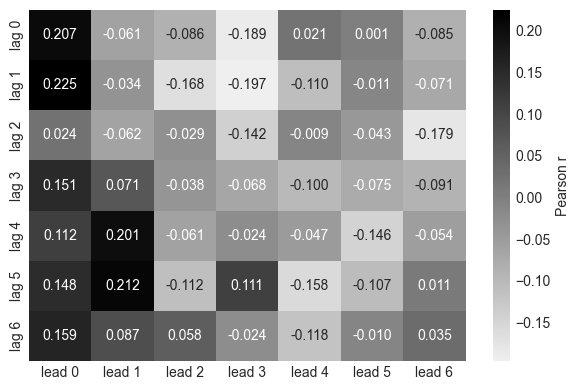

In [86]:
# 7. Lag-lead heat-map
max_lag = max_lead = 6
corr_mat = np.zeros((max_lag + 1, max_lead + 1))

for k in range(max_lag + 1):  # lag of sentiment
    for h in range(max_lead + 1):  # lead of return
        x = sent_series.shift(k)  # shift sentiment by k lags
        y = ret_series.shift(-h)  # shift returns by h leads
        corr_mat[k, h] = x.corr(y)  # calculate Pearson correlation

# Create a DataFrame for the heatmap
heat = pd.DataFrame(
    corr_mat,
    index=[f'lag {k}' for k in range(max_lag + 1)],
    columns=[f'lead {h}' for h in range(max_lead + 1)]
)

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(
    heat,
    annot=True,
    fmt='.3f',
    cmap='binary',
    center=0,
    cbar_kws={'label': 'Pearson r'}
)

plt.tight_layout()
plt.show()

In [73]:
file_path_price = r'C:\Users\Leo Hubmann\Desktop\thesis\data\price_data\bitcoin_2021_2024.csv'
df_price = pd.read_csv(file_path_price, parse_dates=['date'], low_memory=False)
df_price.set_index('date', inplace=True)

btc = df_price.loc['2021-01-01':'2024-12-31'].copy()
daily_ret = np.log(btc['close']).diff().dropna()
vader_path = r'C:\Users\Leo Hubmann\Desktop\BachelorThesis_data\all_daily_vader_sentiment_v2.csv'
df_v = pd.read_csv(vader_path, parse_dates=['date'])

# optional scaling
# vmin, vmax = df_v['daily_vader_sentiment'].min(), df_v['daily_vader_sentiment'].max()
# df_v['vader_scaled'] = 2 * (df_v['daily_vader_sentiment'] - vmin) / (vmax - vmin) - 1

df_v.set_index('date', inplace=True)
finbert_path = r'C:\Users\Leo Hubmann\Desktop\BachelorThesis_data\all_daily_finbert_sentiment_v4.csv'
df_f = pd.read_csv(finbert_path, parse_dates=['date'])

# optional scaling
# fmin, fmax = df_f['daily_finbert_score'].min(), df_f['daily_finbert_score'].max()
# df_f['finbert_scaled'] = 2 * (df_f['daily_finbert_score'] - fmin) / (fmax - fmin) - 1

df_f.set_index('date', inplace=True)
merged = pd.DataFrame({
    'return': daily_ret,
    'vader': df_v['daily_vader_sentiment'],
    'finbert': df_f['daily_finbert_score']
}).dropna()
weekly = pd.DataFrame({
    'ret_w': merged['return'].resample('W-MON').sum(),  # log-return for the week
    'sent_w': merged['vader'].resample('W-MON').mean()  # or 'finbert'
}).dropna()

weekly['d_sent'] = weekly['sent_w'].diff()

In [74]:
btc = df_price.loc['2021-01-01':'2024-12-31'].copy()
daily_ret = np.log(btc['close']).diff().dropna()

# 2. Merge daily series
merged = pd.DataFrame({
    'return': daily_ret,
    'vader' : df_v['daily_vader_sentiment'],
    'finbert': df_f['daily_finbert_score']
}).dropna()

# 3. Weekly aggregation (Monday weeks)
weekly = (merged
          .resample('W-MON')
          .agg({'return':  'sum',
                'vader' :  'mean',
                'finbert': 'mean'})
          .dropna())

weekly.rename(columns={'return':'ret_w',
                       'vader' :'vader_w',
                       'finbert':'finbert_w'}, inplace=True)

# 4. Δ-sentiment and z-scores
weekly['d_vader']   = weekly['vader_w'].diff()
weekly['d_finbert'] = weekly['finbert_w'].diff()

weekly['z_vader']   = zscore(weekly['d_vader'].dropna()).reindex(weekly.index)
weekly['z_finbert'] = zscore(weekly['d_finbert'].dropna()).reindex(weekly.index)

# 5. Equal-weight composite
weekly['d_comb'] = 0.5*(weekly['z_vader'] + weekly['z_finbert'])

# 6. Remove initial NaNs
weekly = weekly.dropna(subset=['ret_w','d_comb'])


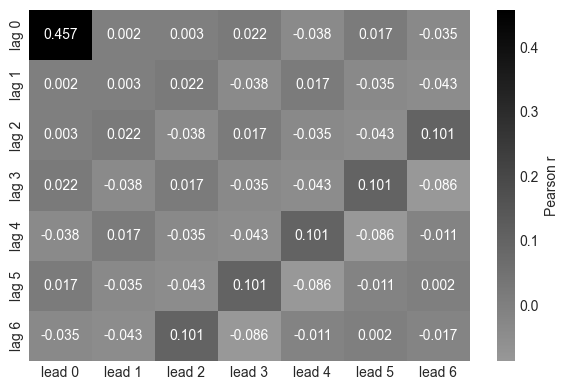

In [77]:
# 7. Lag-lead heat-map
max_lag = max_lead = 6
corr_mat = np.zeros((max_lag+1, max_lead+1))

for k in range(max_lag+1):
    for h in range(max_lead+1):
        x = weekly['d_comb'].shift(k)
        y = weekly['ret_w'].shift(-h)
        corr_mat[k, h] = x.corr(y)

heat = pd.DataFrame(corr_mat,
                    index=[f'lag {k}' for k in range(max_lag+1)],
                    columns=[f'lead {h}' for h in range(max_lead+1)])

plt.figure(figsize=(6,4))
sns.heatmap(heat, annot=True, fmt='.3f', cmap='binary', center=0,
            cbar_kws={'label':'Pearson r'})
plt.savefig('heat_combined.png', dpi=300)

plt.tight_layout(); plt.show()

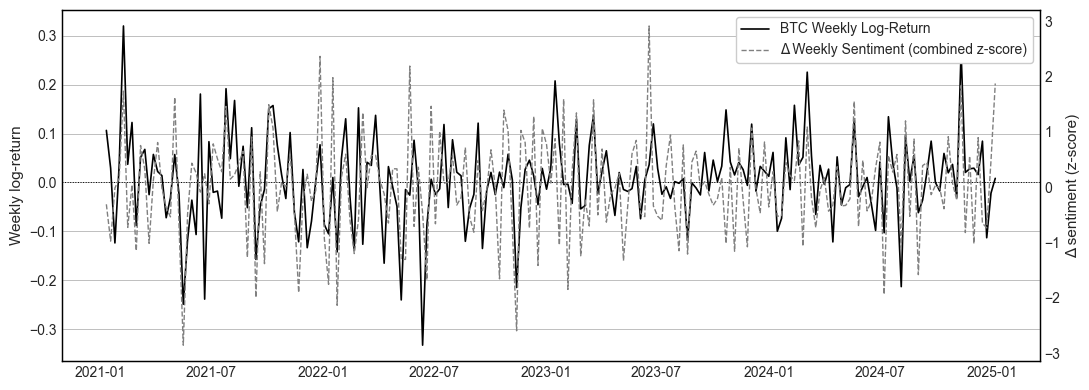

In [76]:


plt.style.use('seaborn-v0_8-whitegrid')

fig, ax_ret = plt.subplots(figsize=(11, 4))
ax_sent = ax_ret.twinx()

ax_ret.plot(
    weekly.index, weekly['ret_w'],
    color='black', linewidth=1.2, label='BTC Weekly Log-Return'
)

ax_sent.plot(
    weekly.index, weekly['d_comb'],
    color='gray', linestyle='--', linewidth=1.0,
    label='Δ Weekly Sentiment (combined z-score)'
)

ax_ret.set_ylabel('Weekly log-return',        fontsize=11)
ax_sent.set_ylabel('Δ sentiment (z-score)',   fontsize=11)

ax_ret.axhline(0, color='black', linewidth=.7, linestyle=':')
ax_sent.grid(False)                          # keep only the left-axis grid
ax_ret.grid(True, axis='y', linewidth=0.5, color='grey', alpha=0.7)
ax_ret.grid(False, axis='x')

# black spines for the right axis so both y-axes look identical
for side in ['top', 'right', 'left', 'bottom']:
    ax_sent.spines[side].set_color('black')

# --- 3.  legend ---------------------------------------------------------------
h1, l1 = ax_ret.get_legend_handles_labels()
h2, l2 = ax_sent.get_legend_handles_labels()
ax_ret.legend(h1 + h2, l1 + l2,
              loc='upper right', frameon=True, framealpha=1)

plt.tight_layout()
plt.savefig('plot_combined_sent.png', dpi=300)
plt.show()


In [48]:
weekly = (merged
          .resample('W-MON')
          .agg({'return':  'sum',        # weekly log-return
                'vader' :  'mean',
                'finbert': 'mean'})
          .dropna())

weekly.rename(columns={'return': 'ret_w',
                       'vader' : 'vader_w',
                       'finbert': 'finbert_w'}, inplace=True)

In [49]:
weekly['d_vader']   = weekly['vader_w'].diff()
weekly['d_finbert'] = weekly['finbert_w'].diff()

weekly['z_vader']   = zscore(weekly['d_vader'].dropna())
weekly['z_finbert'] = zscore(weekly['d_finbert'].dropna())

weekly[['z_vader','z_finbert']] = weekly[['z_vader','z_finbert']].reindex(weekly.index)

In [50]:
weekly['d_comb'] = 0.5*(weekly['z_vader'] + weekly['z_finbert'])


In [51]:
weekly = weekly.dropna(subset=['ret_w','d_vader','d_finbert','d_comb'])


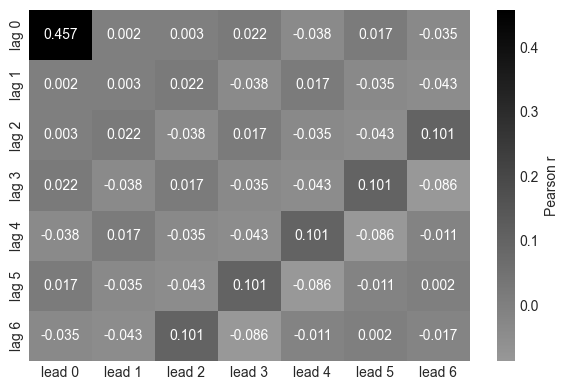

In [52]:
max_lag, max_lead = 6, 6
corr_mat = np.zeros((max_lag+1, max_lead+1))

for k in range(max_lag+1):
    for h in range(max_lead+1):
        x = weekly['d_comb'].shift(k)
        y = weekly['ret_w'].shift(-h)
        corr_mat[k, h] = x.corr(y)

heat = pd.DataFrame(corr_mat,
                    index=[f'lag {k}'  for k in range(max_lag+1)],
                    columns=[f'lead {h}' for h in range(max_lead+1)])

plt.figure(figsize=(6,4))
sns.heatmap(heat, annot=True, fmt='.3f', cmap='binary', center=0,
            cbar_kws={'label':'Pearson r'})

plt.tight_layout(); plt.show()